# Experimentos de Aprendizado por Reforço em Cliff World 10x10

Este notebook apresenta uma comparação completa entre algoritmos clássicos de RL (baseados em valor) e algoritmos de gradiente de política, aplicados a um ambiente Cliff World 10x10 com características desafiadoras.

---

## 📚 Sumário

1. [Configuração do Ambiente](#1-configuração-do-ambiente)
2. [SARSA - State-Action-Reward-State-Action](#2-sarsa)
3. [Q-Learning](#3-q-learning)
4. [Expected SARSA](#4-expected-sarsa)
5. [REINFORCE - Monte Carlo Policy Gradient](#5-reinforce)
6. [REINFORCE com Baseline](#6-reinforce-com-baseline)
7. [Actor-Critic (One-Step)](#7-actor-critic)
8. [Comparação Final](#8-comparação-final)

---

In [1]:
## 1. Configuração do Ambiente

### 1.1 Imports Necessários


import numpy as np
import matplotlib.pyplot as plt
from environment import create_custom_gridworld, print_gridworld_info
from algorithms import sarsa, q_learning, expected_sarsa, get_greedy_policy
from algorithms_extended import reinforce, reinforce_baseline, actor_critic
from visualization import (visualize_gridworld, visualize_q_values, 
                           plot_learning_curves, compare_algorithms)
from visualization_extended import (visualize_stochastic_policy, plot_policy_arrows,
                                   plot_policy_gradient_learning, plot_value_and_policy)

# Configurações para reprodutibilidade
np.random.seed(42)

#plt.style.use('seaborn-v0_8-darkgrid')

### 1.2 Criação do Cliff World 10x10

**Descrição do Ambiente:**

O Cliff World é um ambiente clássico de RL que testa a capacidade dos algoritmos de encontrar caminhos seguros versus caminhos ótimos. Nosso ambiente 10x10 possui:

- **Estado inicial (S)**: Canto inferior esquerdo `(9, 0)`
- **Estado objetivo (G)**: Canto inferior direito `(9, 9)`
- **Abismos (C)**: Toda a linha inferior entre S e G `(9, 1)` até `(9, 8)`
- **Recompensas**:
  - Cair no abismo: **-100**
  - Alcançar objetivo: **+10**
  - Cada passo: **-1** (incentiva caminhos curtos)

**Layout:**
```
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ][ ][ ][ ]
[S][C][C][C][C][C][C][C][C][G]
```

In [126]:
# Cria ambiente Cliff World 10x10
gw = create_custom_gridworld(
    rows=6,
    cols=10,
    walls=[
        (3,1),(2,2),
        (3,3),(2,4),
        (3,5),(2,6),
        (3,7),(2,8),
          ],  # Sem paredes internas
    terminals={
        # Abismos na última linha (exceto cantos)
        **{(5, col): -10.0 for col in range(1, 9)},
        # Abismos na primeira linha (exceto cantos)
        **{(0, col): -50.0 for col in range(1, 9)},
        # Objetivo no canto inferior direito
        (5, 9): 10.0,
        (0, 9): 10.0
    },
    gamma=0.99,
    noise=0.0,  # Determinístico
    living_reward=-1.0
)

# Exibe informações
print_gridworld_info(gw)

INFORMAÇÕES DO GRIDWORLD
Dimensões: 6 linhas x 10 colunas
Total de estados: 52
Paredes: 8
Estados terminais: 18
Fator de desconto (γ): 0.99
Ruído: 0.0
Living reward: -1.0
Ações disponíveis: ['N', 'S', 'L', 'O']

Paredes: [(2, 2), (2, 4), (2, 6), (2, 8), (3, 1), (3, 3), (3, 5), (3, 7)]

Estados terminais:
  (0, 1): reward = -50.0
  (0, 2): reward = -50.0
  (0, 3): reward = -50.0
  (0, 4): reward = -50.0
  (0, 5): reward = -50.0
  (0, 6): reward = -50.0
  (0, 7): reward = -50.0
  (0, 8): reward = -50.0
  (0, 9): reward = 10.0
  (5, 1): reward = -10.0
  (5, 2): reward = -10.0
  (5, 3): reward = -10.0
  (5, 4): reward = -10.0
  (5, 5): reward = -10.0
  (5, 6): reward = -10.0
  (5, 7): reward = -10.0
  (5, 8): reward = -10.0
  (5, 9): reward = 10.0


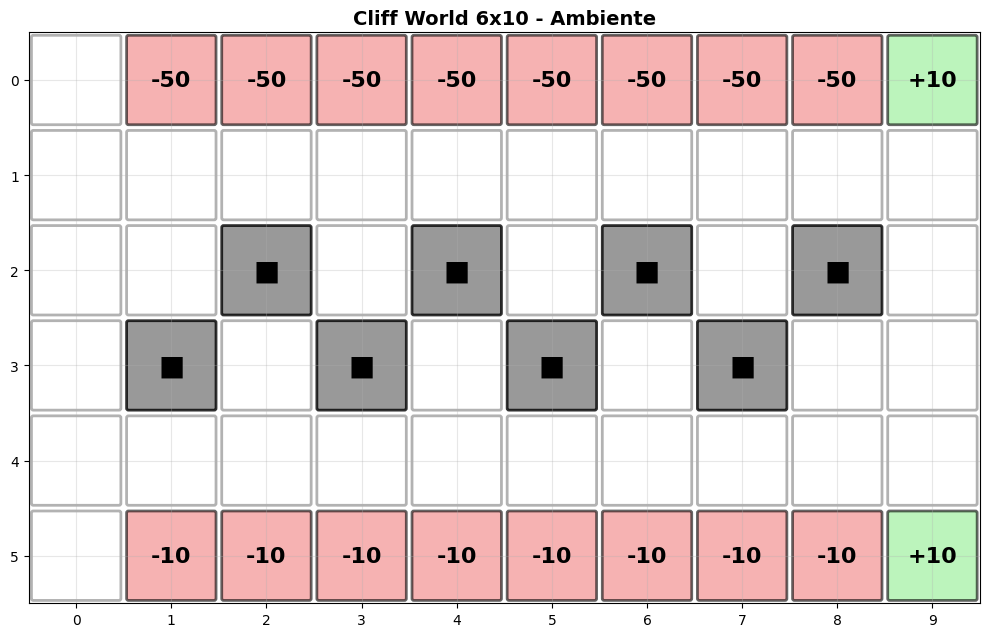

In [127]:
### 1.3 Visualização do Ambiente


# Visualiza o ambiente
visualize_gridworld(
    gw,
    title="Cliff World 6x10 - Ambiente",
    figsize=(10, 10)
)

**Ponto de partida típico para treinamento:**

```python
# Define estado inicial fixo para todos os experimentos
INITIAL_STATE = (9, 0)  # Canto inferior esquerdo

print(f"Estado inicial: {INITIAL_STATE}")
print(f"Estado objetivo: (9, 9)")
print(f"Número de abismos: {len([s for s in gw.terminal_states if gw.terminal_states[s] < 0])}")
```

In [128]:
# Define estado inicial fixo para todos os experimentos
INITIAL_STATE = (5, 0)  # Canto inferior esquerdo

print(f"Estado inicial: {INITIAL_STATE}")
print(f"Estados objetivos: (5, 9)")
print(f"Número de abismos: {len([s for s in gw.terminal_states if gw.terminal_states[s] < 0])}")

Estado inicial: (5, 0)
Estados objetivos: (5, 9)
Número de abismos: 16


## 2. SARSA - State-Action-Reward-State-Action

### 2.1 Intuição

**SARSA** é um algoritmo **on-policy** de Temporal Difference (TD). Ele aprende o valor $Q(s,a)$ da política que está **atualmente seguindo** (incluindo a exploração $\epsilon$-greedy).

**Características:**
- ✅ Conservador: aprende políticas mais seguras
- ✅ Considera a exploração durante o aprendizado
- ❌ Pode ser mais lento para convergir
- 📊 Ideal quando a exploração tem custos reais

### 2.2 Pseudocódigo

```
Inicializar Q(s,a) arbitrariamente
Para cada episódio:
    S ← estado inicial
    A ← ação escolhida por ε-greedy usando Q
    
    Repetir para cada passo do episódio:
        Executar ação A, observar R, S'
        A' ← ação escolhida por ε-greedy usando Q (do próximo estado)
        
        Q(S,A) ← Q(S,A) + α[R + γQ(S',A') - Q(S,A)]
        
        S ← S'
        A ← A'
    até S ser terminal
```

### 2.3 Equação de Atualização

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \right]$$

**Nota importante:** O algoritmo usa $Q(S_{t+1}, A_{t+1})$ onde $A_{t+1}$ é escolhida pela política atual (ε-greedy), não pela política gulosa.

In [129]:
### 2.4 Treinamento do SARSA

print("="*80)
print("TREINANDO SARSA")
print("="*80)

# Hiperparâmetros
N_EPISODES = 3000
ALPHA = 0.1      # Taxa de aprendizado
EPSILON = 0.1    # Exploração
GAMMA = 0.99     # Desconto (já definido no ambiente)

# Treina SARSA
Q_sarsa, rewards_sarsa = sarsa(
    gw,
    n_episodes=N_EPISODES,
    alpha=ALPHA,
    epsilon=EPSILON,
    initial_state=INITIAL_STATE,
    verbose=True
)

print(f"\n✓ Treinamento concluído!")
print(f"Recompensa média últimos 100 episódios: {np.mean(rewards_sarsa[-100:]):.2f}")

TREINANDO SARSA
Episódio 100/3000 - Reward médio: -51.73
Episódio 200/3000 - Reward médio: -14.41
Episódio 300/3000 - Reward médio: -3.03
Episódio 400/3000 - Reward médio: -4.10
Episódio 500/3000 - Reward médio: -5.11
Episódio 600/3000 - Reward médio: -3.61
Episódio 700/3000 - Reward médio: -4.27
Episódio 800/3000 - Reward médio: -4.62
Episódio 900/3000 - Reward médio: -4.29
Episódio 1000/3000 - Reward médio: -4.38
Episódio 1100/3000 - Reward médio: -4.52
Episódio 1200/3000 - Reward médio: -4.51
Episódio 1300/3000 - Reward médio: -3.45
Episódio 1400/3000 - Reward médio: -4.73
Episódio 1500/3000 - Reward médio: -3.98
Episódio 1600/3000 - Reward médio: -4.28
Episódio 1700/3000 - Reward médio: -3.86
Episódio 1800/3000 - Reward médio: -9.43
Episódio 1900/3000 - Reward médio: -4.64
Episódio 2000/3000 - Reward médio: -5.38
Episódio 2100/3000 - Reward médio: -4.87
Episódio 2200/3000 - Reward médio: -4.56
Episódio 2300/3000 - Reward médio: -4.70
Episódio 2400/3000 - Reward médio: -5.04
Episódi

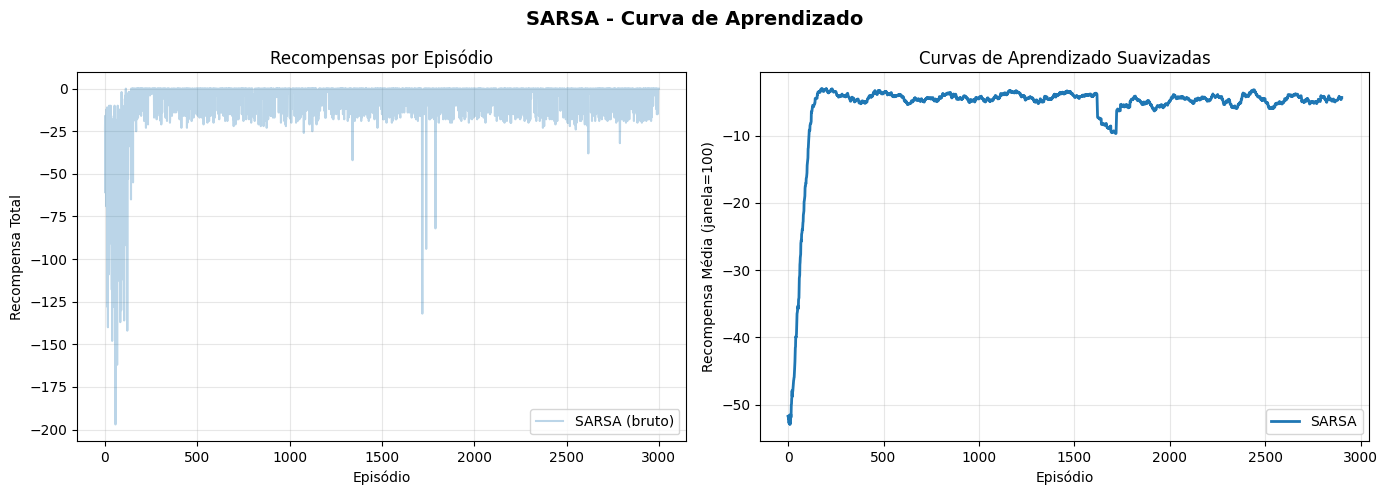

In [130]:
### 2.5 Visualização dos Resultados - SARSA

#### Curva de Aprendizado


plot_learning_curves(
    {'SARSA': rewards_sarsa},
    title="SARSA - Curva de Aprendizado",
    figsize=(14, 5)
)

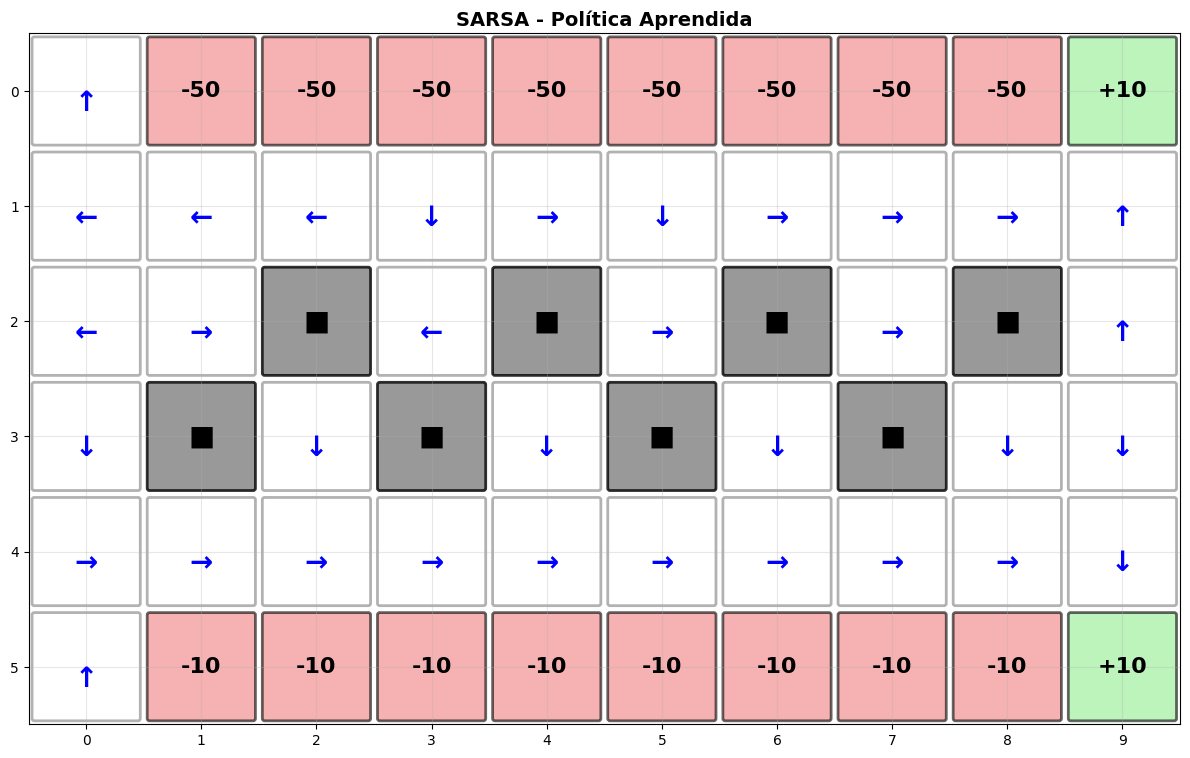

In [131]:
#### Política Aprendida


# Extrai política gulosa
policy_sarsa = get_greedy_policy(Q_sarsa, gw)

# Visualiza política
visualize_gridworld(
    gw,
    policy=policy_sarsa,
    title="SARSA - Política Aprendida",
    figsize=(12, 12)
)

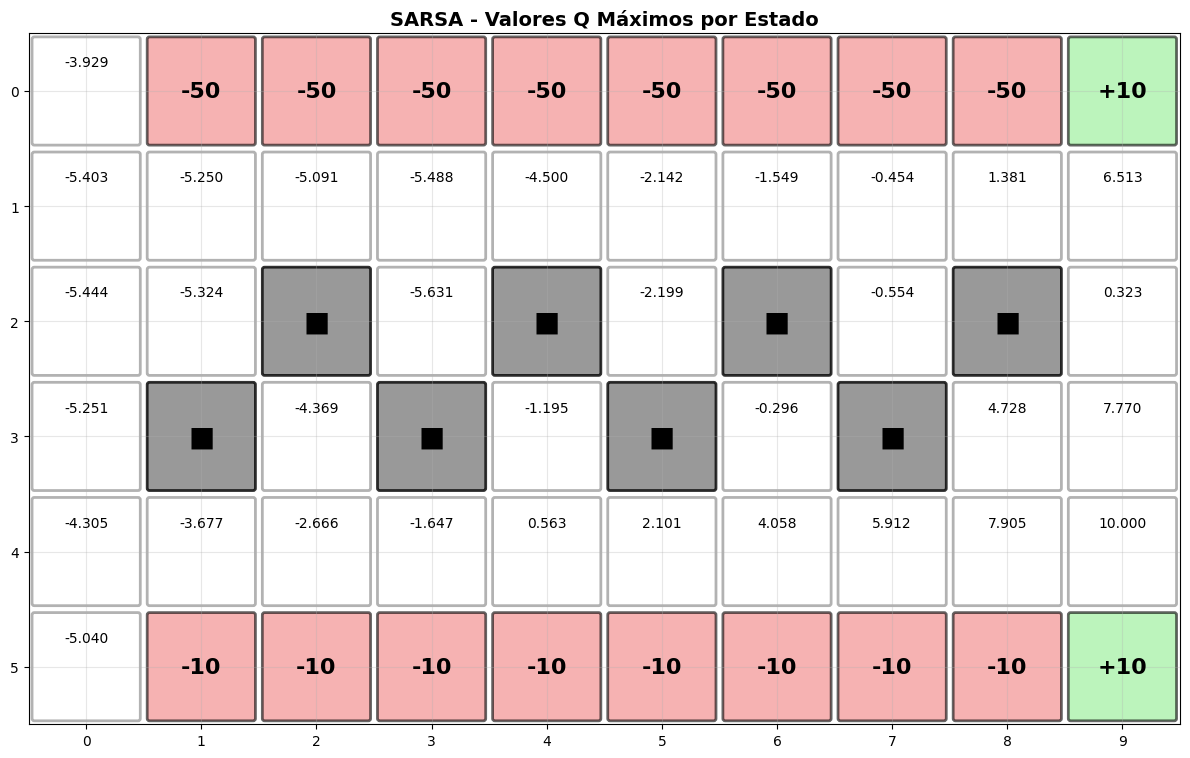

In [132]:
#### Valores Q Aprendidos


# Visualiza valores máximos por estado
visualize_q_values(
    Q_sarsa,
    gw,
    title="SARSA - Valores Q Máximos por Estado",
    figsize=(12, 12)
)

## 3. Q-Learning

### 3.1 Intuição

**Q-Learning** é um algoritmo **off-policy** de TD. Ele aprende o valor $Q(s,a)$ da política **ótima** (gulosa), independentemente da política que está seguindo para exploração.

**Características:**
- ✅ Aprende a política ótima diretamente
- ✅ Converge mais rápido
- ⚠️ Mais agressivo: pode encontrar caminhos arriscados
- 📊 Ideal quando podemos explorar livremente

### 3.2 Pseudocódigo

```
Inicializar Q(s,a) arbitrariamente
Para cada episódio:
    S ← estado inicial
    
    Repetir para cada passo do episódio:
        A ← ação escolhida por ε-greedy usando Q
        Executar ação A, observar R, S'
        
        Q(S,A) ← Q(S,A) + α[R + γ max_a' Q(S',a') - Q(S,A)]
        
        S ← S'
    até S ser terminal
```

### 3.3 Equação de Atualização

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a) - Q(S_t, A_t) \right]$$

**Diferença chave:** Usa $\max_a Q(S_{t+1}, a)$ (política gulosa) ao invés de $Q(S_{t+1}, A_{t+1})$ (política atual).

In [133]:
### 3.4 Treinamento do Q-Learning


print("="*80)
print("TREINANDO Q-LEARNING")
print("="*80)

# Treina Q-Learning (mesmos hiperparâmetros)
Q_qlearning, rewards_qlearning = q_learning(
    gw,
    n_episodes=N_EPISODES,
    alpha=ALPHA,
    epsilon=EPSILON,
    initial_state=INITIAL_STATE,
    verbose=True
)

print(f"\n✓ Treinamento concluído!")
print(f"Recompensa média últimos 100 episódios: {np.mean(rewards_qlearning[-100:]):.2f}")

TREINANDO Q-LEARNING
Episódio 100/3000 - Reward médio: -44.99
Episódio 200/3000 - Reward médio: -12.69
Episódio 300/3000 - Reward médio: -4.23
Episódio 400/3000 - Reward médio: -4.63
Episódio 500/3000 - Reward médio: -4.24
Episódio 600/3000 - Reward médio: -4.82
Episódio 700/3000 - Reward médio: -3.69
Episódio 800/3000 - Reward médio: -3.65
Episódio 900/3000 - Reward médio: -5.14
Episódio 1000/3000 - Reward médio: -3.80
Episódio 1100/3000 - Reward médio: -4.25
Episódio 1200/3000 - Reward médio: -3.58
Episódio 1300/3000 - Reward médio: -4.92
Episódio 1400/3000 - Reward médio: -4.31
Episódio 1500/3000 - Reward médio: -4.24
Episódio 1600/3000 - Reward médio: -2.76
Episódio 1700/3000 - Reward médio: -3.71
Episódio 1800/3000 - Reward médio: -4.05
Episódio 1900/3000 - Reward médio: -4.18
Episódio 2000/3000 - Reward médio: -3.45
Episódio 2100/3000 - Reward médio: -4.11
Episódio 2200/3000 - Reward médio: -3.90
Episódio 2300/3000 - Reward médio: -3.83
Episódio 2400/3000 - Reward médio: -4.10
Ep

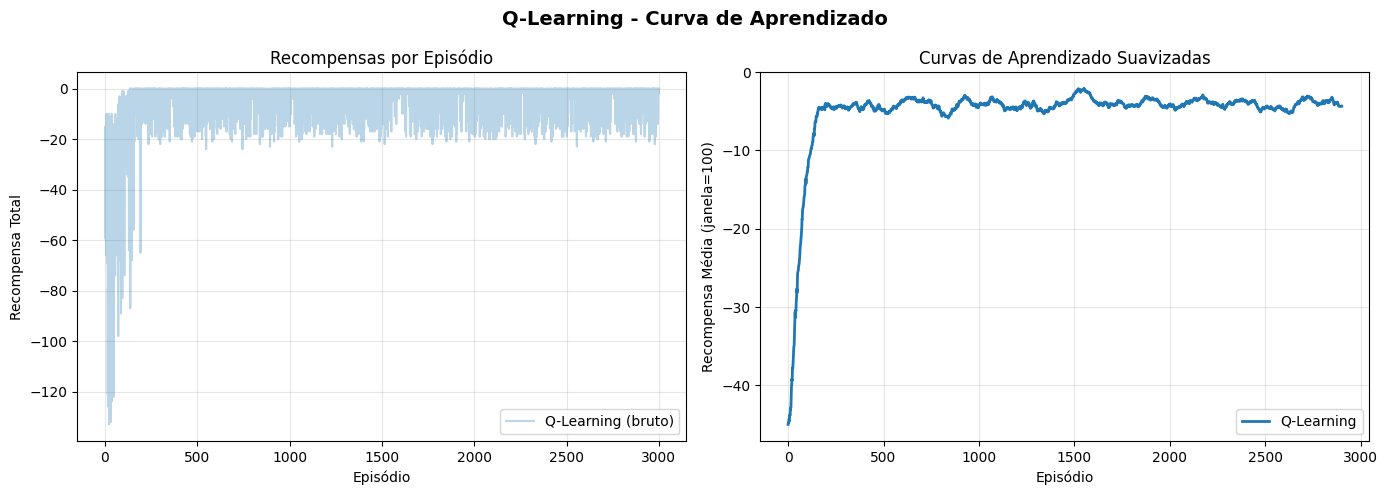

In [134]:
### 3.5 Visualização dos Resultados - Q-Learning

#### Curva de Aprendizado


plot_learning_curves(
    {'Q-Learning': rewards_qlearning},
    title="Q-Learning - Curva de Aprendizado",
    figsize=(14, 5)
)

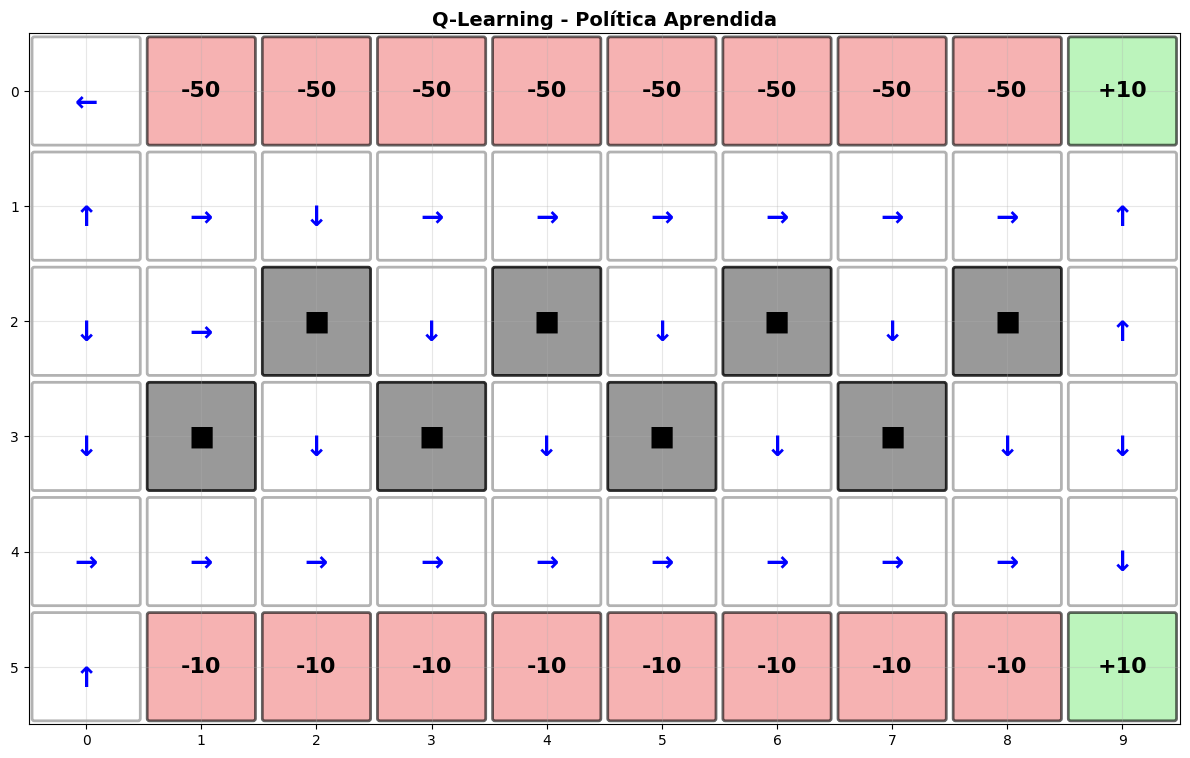

In [135]:
#### Política Aprendida


# Extrai política gulosa
policy_qlearning = get_greedy_policy(Q_qlearning, gw)

# Visualiza política
visualize_gridworld(
    gw,
    policy=policy_qlearning,
    title="Q-Learning - Política Aprendida",
    figsize=(12, 12)
)

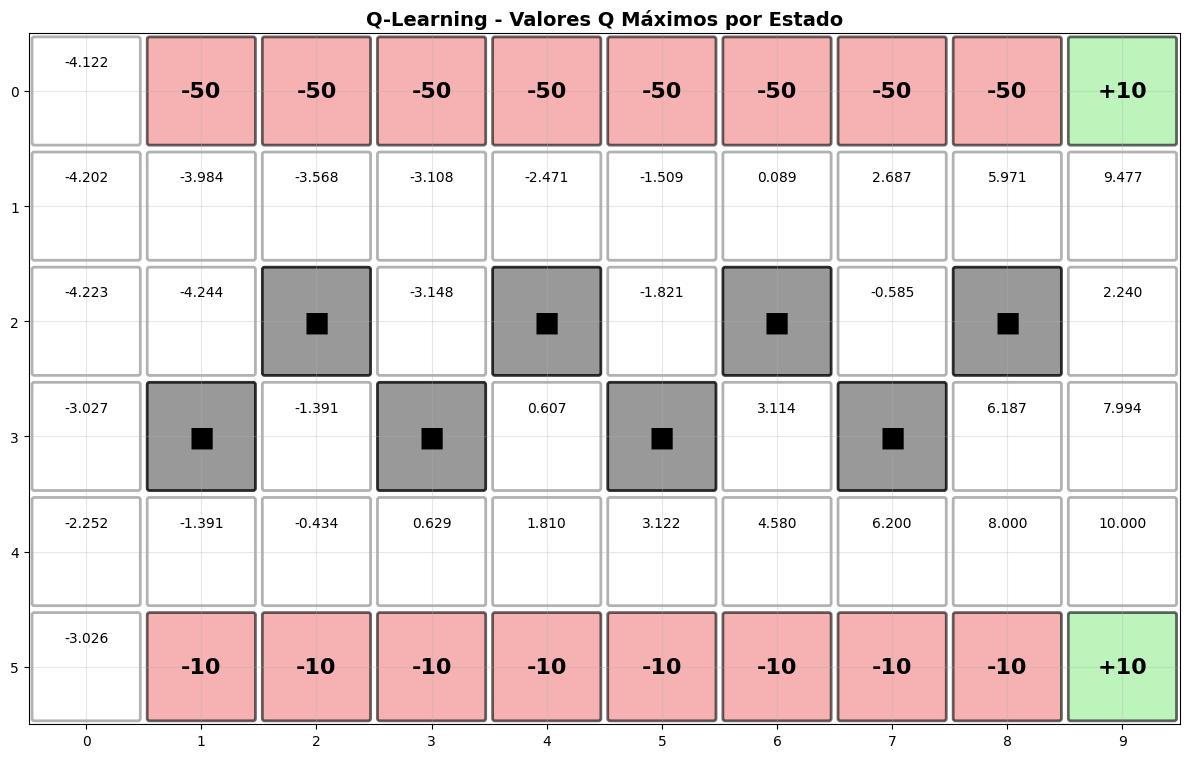

In [136]:
#### Valores Q Aprendidos


# Visualiza valores máximos por estado
visualize_q_values(
    Q_qlearning,
    gw,
    title="Q-Learning - Valores Q Máximos por Estado",
    figsize=(12, 12)
)

## 4. Expected SARSA

### 4.1 Intuição

**Expected SARSA** é uma variação do SARSA que usa o **valor esperado** das ações no próximo estado ao invés de uma ação específica. Isso reduz a variância das atualizações.

**Características:**
- ✅ Menos variância que SARSA
- ✅ Mais estável que Q-Learning
- ✅ Pode ser on-policy ou off-policy
- 📊 Bom compromisso entre SARSA e Q-Learning

### 4.2 Pseudocódigo

```
Inicializar Q(s,a) arbitrariamente
Para cada episódio:
    S ← estado inicial
    
    Repetir para cada passo do episódio:
        A ← ação escolhida por ε-greedy usando Q
        Executar ação A, observar R, S'
        
        expected_Q ← Σ_a' π(a'|S') Q(S',a')
        Q(S,A) ← Q(S,A) + α[R + γ expected_Q - Q(S,A)]
        
        S ← S'
    até S ser terminal
```

### 4.3 Equação de Atualização

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \mathbb{E}_\pi[Q(S_{t+1}, \cdot)] - Q(S_t, A_t) \right]$$

onde:

$$\mathbb{E}_\pi[Q(S_{t+1}, \cdot)] = \sum_{a} \pi(a|S_{t+1}) Q(S_{t+1}, a)$$

Para política $\epsilon$-greedy:

$$\mathbb{E}_\pi[Q(s, \cdot)] = (1-\epsilon) \max_a Q(s,a) + \epsilon \cdot \frac{1}{|A|} \sum_a Q(s,a)$$

In [137]:
### 4.4 Treinamento do Expected SARSA


print("="*80)
print("TREINANDO EXPECTED SARSA")
print("="*80)

# Treina Expected SARSA
Q_expected, rewards_expected = expected_sarsa(
    gw,
    n_episodes=N_EPISODES,
    alpha=ALPHA,
    epsilon=EPSILON,
    initial_state=INITIAL_STATE,
    verbose=True
)

print(f"\n✓ Treinamento concluído!")
print(f"Recompensa média últimos 100 episódios: {np.mean(rewards_expected[-100:]):.2f}")

TREINANDO EXPECTED SARSA
Episódio 100/3000 - Reward médio: -46.55
Episódio 200/3000 - Reward médio: -12.09
Episódio 300/3000 - Reward médio: -5.64
Episódio 400/3000 - Reward médio: -3.98
Episódio 500/3000 - Reward médio: -3.95
Episódio 600/3000 - Reward médio: -4.05
Episódio 700/3000 - Reward médio: -4.06
Episódio 800/3000 - Reward médio: -4.92
Episódio 900/3000 - Reward médio: -4.99
Episódio 1000/3000 - Reward médio: -3.56
Episódio 1100/3000 - Reward médio: -4.37
Episódio 1200/3000 - Reward médio: -4.33
Episódio 1300/3000 - Reward médio: -5.12
Episódio 1400/3000 - Reward médio: -5.49
Episódio 1500/3000 - Reward médio: -3.54
Episódio 1600/3000 - Reward médio: -3.88
Episódio 1700/3000 - Reward médio: -2.96
Episódio 1800/3000 - Reward médio: -3.48
Episódio 1900/3000 - Reward médio: -3.53
Episódio 2000/3000 - Reward médio: -3.31
Episódio 2100/3000 - Reward médio: -5.23
Episódio 2200/3000 - Reward médio: -3.69
Episódio 2300/3000 - Reward médio: -3.89
Episódio 2400/3000 - Reward médio: -3.5

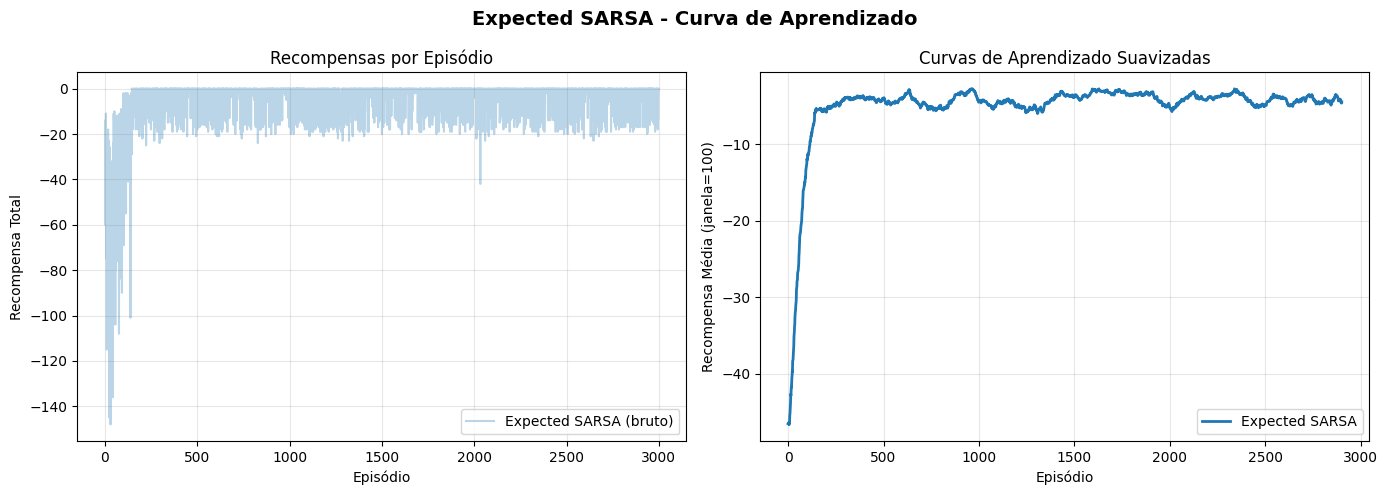

In [138]:
### 4.5 Visualização dos Resultados - Expected SARSA

#### Curva de Aprendizado


plot_learning_curves(
    {'Expected SARSA': rewards_expected},
    title="Expected SARSA - Curva de Aprendizado",
    figsize=(14, 5)
)

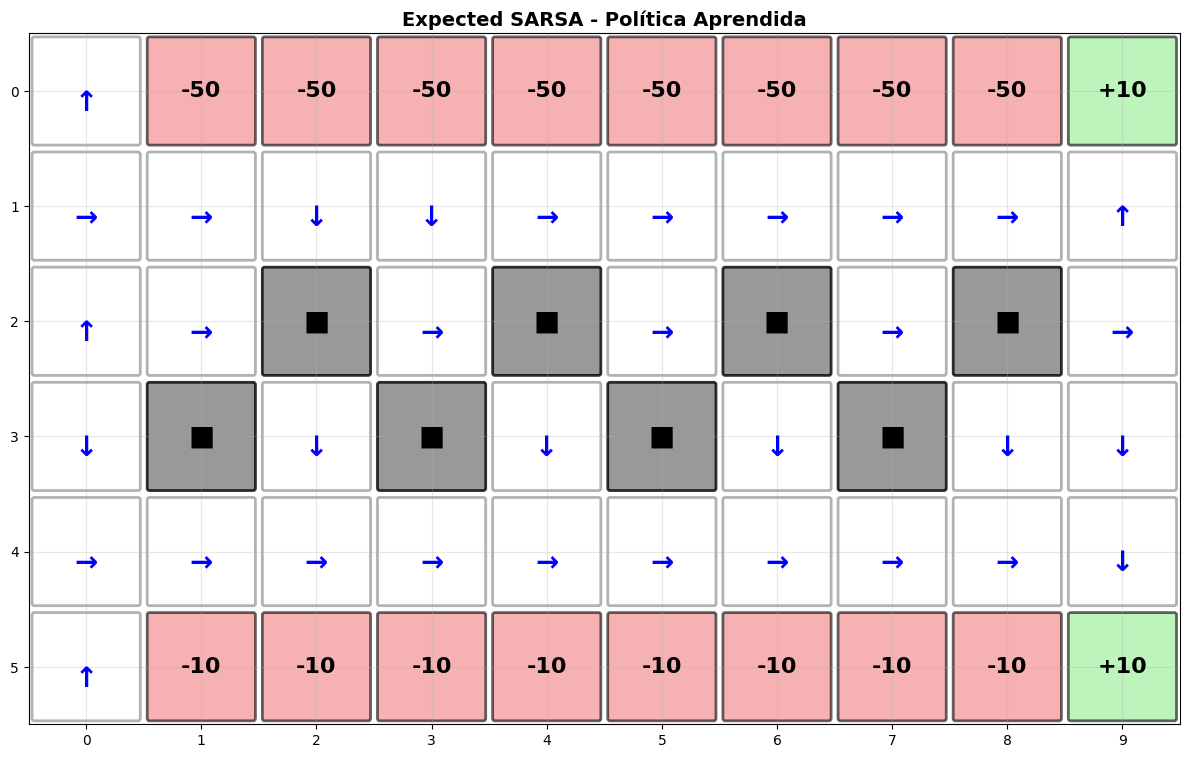

In [139]:
#### Política Aprendida


# Extrai política gulosa
policy_expected = get_greedy_policy(Q_expected, gw)

# Visualiza política
visualize_gridworld(
    gw,
    policy=policy_expected,
    title="Expected SARSA - Política Aprendida",
    figsize=(12, 12)
)

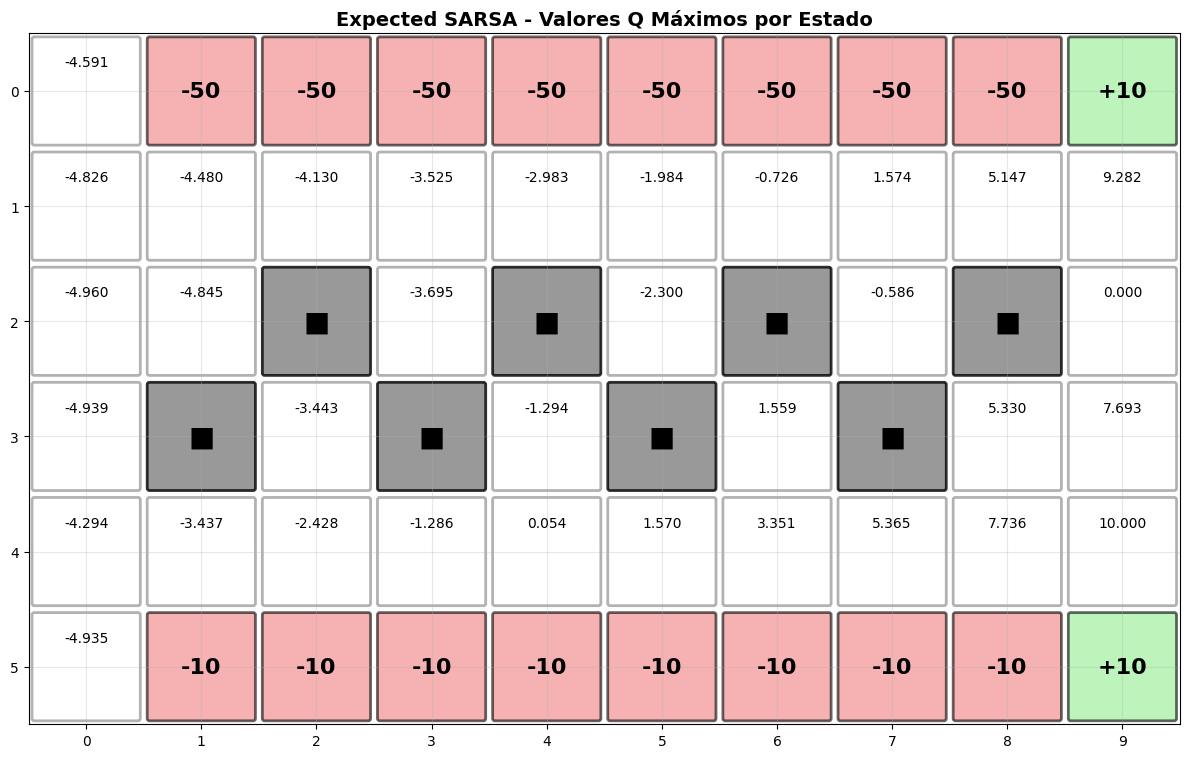

In [140]:
#### Valores Q Aprendidos


# Visualiza valores máximos por estado
visualize_q_values(
    Q_expected,
    gw,
    title="Expected SARSA - Valores Q Máximos por Estado",
    figsize=(12, 12)
)

---

## 5. REINFORCE - Monte Carlo Policy Gradient

### 5.1 Intuição

**REINFORCE** é um algoritmo de **gradiente de política** que parametriza diretamente a política $\pi(a|s, \theta)$ e otimiza os parâmetros $\theta$ para maximizar a recompensa esperada.

**Diferenças fundamentais:**
- ❌ Não aprende valores Q(s,a)
- ✅ Aprende política estocástica diretamente
- ✅ Funciona bem em espaços contínuos
- ⚠️ Alta variância (usa retornos completos)

**Representação da Política:**
Usamos política **softmax** (Boltzmann):

$$\pi(a|s, \theta) = \frac{e^{h(s,a,\theta)}}{\sum_{b} e^{h(s,b,\theta)}}$$

onde $h(s,a,\theta) = \theta^T \phi(s,a)$ são as "preferências" e $\phi(s,a)$ são features (one-hot encoding no nosso caso).

### 5.2 Pseudocódigo

```
Inicializar θ (parâmetros da política) arbitrariamente

Para cada episódio:
    Gerar episódio S₀, A₀, R₁, ..., Sₜ, Aₜ, Rₜ₊₁ seguindo π(·|·,θ)
    
    Para cada passo t do episódio:
        Gₜ ← Σₖ₌₀^∞ γᵏ Rₜ₊ₖ₊₁   # Retorno descontado
        
        θ ← θ + α γᵗ Gₜ ∇log π(Aₜ|Sₜ,θ)
```

### 5.3 Equação de Atualização

**Gradiente do objetivo:**

$$\nabla J(\theta) = \mathbb{E}_\pi \left[ G_t \nabla \log \pi(A_t|S_t, \theta) \right]$$

**Atualização de parâmetros:**

$$\theta \leftarrow \theta + \alpha \gamma^t G_t \nabla \log \pi(A_t|S_t, \theta)$$

**Gradiente para política softmax:**

$$\nabla \log \pi(a|s, \theta) = \phi(s,a) - \sum_{b} \pi(b|s,\theta) \phi(s,b)$$

In [164]:
### 5.4 Treinamento do REINFORCE


print("="*80)
print("TREINANDO REINFORCE")
print("="*80)

# Hiperparâmetros para REINFORCE
N_EPISODES_PG =50000  # Algoritmos PG geralmente precisam de mais episódios
ALPHA_THETA = 2**-9   # Taxa de aprendizado para parâmetros da política (~0.002)
GAMMA_PG = 0.99

# Treina REINFORCE
theta_reinforce, rewards_reinforce = reinforce(
    gw,
    n_episodes=N_EPISODES_PG,
    alpha_theta=ALPHA_THETA,
    gamma=GAMMA_PG,
    initial_state=INITIAL_STATE,
    verbose=True
)

print(f"\n✓ Treinamento concluído!")
print(f"Recompensa média últimos 100 episódios: {np.mean(rewards_reinforce[-100:]):.2f}")

TREINANDO REINFORCE
EpisÃ³dio 100/50000 - Reward mÃ©dio: -15.41
EpisÃ³dio 200/50000 - Reward mÃ©dio: -12.55
EpisÃ³dio 300/50000 - Reward mÃ©dio: -11.31
EpisÃ³dio 400/50000 - Reward mÃ©dio: -11.87
EpisÃ³dio 500/50000 - Reward mÃ©dio: -11.22
EpisÃ³dio 600/50000 - Reward mÃ©dio: -10.68
EpisÃ³dio 700/50000 - Reward mÃ©dio: -10.28
EpisÃ³dio 800/50000 - Reward mÃ©dio: -10.30
EpisÃ³dio 900/50000 - Reward mÃ©dio: -10.39
EpisÃ³dio 1000/50000 - Reward mÃ©dio: -10.14
EpisÃ³dio 1100/50000 - Reward mÃ©dio: -10.42
EpisÃ³dio 1200/50000 - Reward mÃ©dio: -10.18
EpisÃ³dio 1300/50000 - Reward mÃ©dio: -10.19
EpisÃ³dio 1400/50000 - Reward mÃ©dio: -10.19
EpisÃ³dio 1500/50000 - Reward mÃ©dio: -10.28
EpisÃ³dio 1600/50000 - Reward mÃ©dio: -10.12
EpisÃ³dio 1700/50000 - Reward mÃ©dio: -10.10
EpisÃ³dio 1800/50000 - Reward mÃ©dio: -10.11
EpisÃ³dio 1900/50000 - Reward mÃ©dio: -10.14
EpisÃ³dio 2000/50000 - Reward mÃ©dio: -10.09
EpisÃ³dio 2100/50000 - Reward mÃ©dio: -10.13
EpisÃ³dio 2200/50000 - Reward mÃ©dio: -10.06

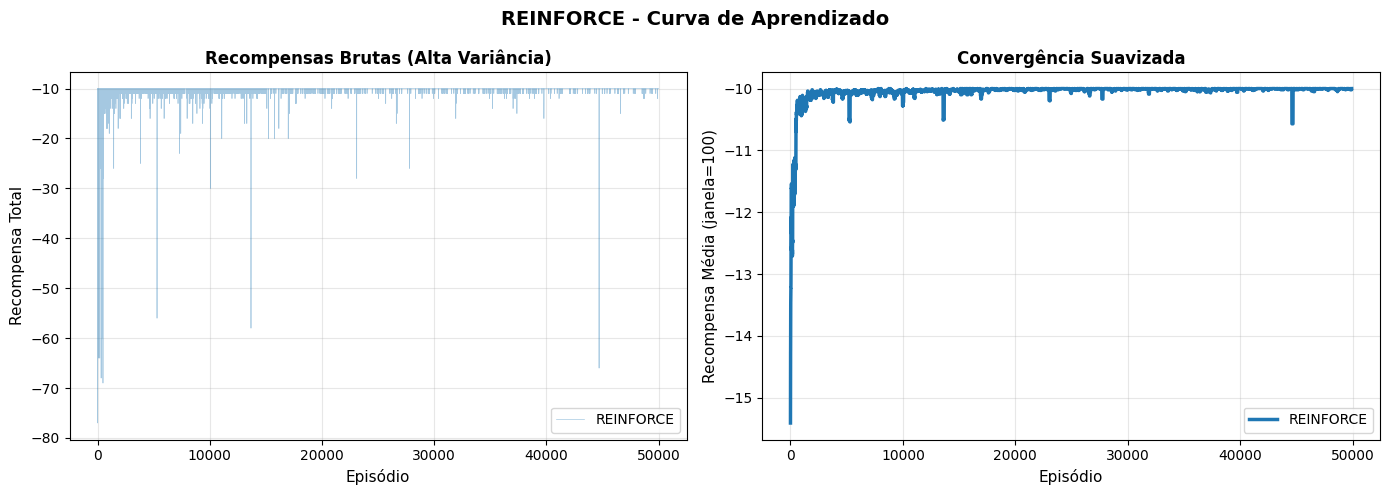

In [165]:
### 5.5 Visualização dos Resultados - REINFORCE

#### Curva de Aprendizado


plot_policy_gradient_learning(
    {'REINFORCE': rewards_reinforce},
    title="REINFORCE - Curva de Aprendizado",
    figsize=(14, 5)
)

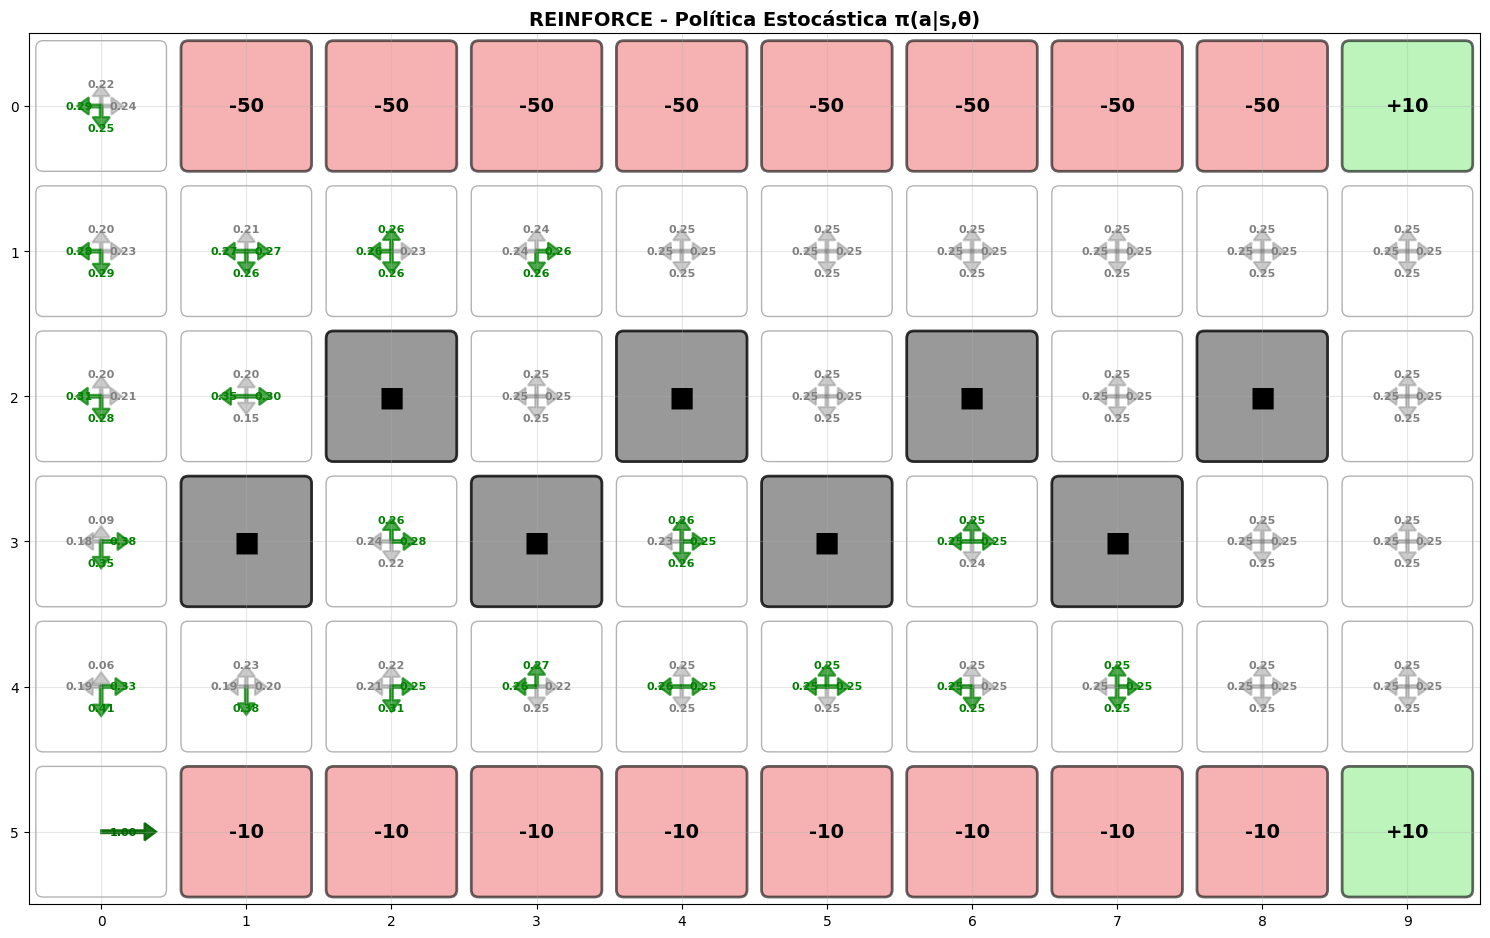

In [166]:
#### Política Estocástica Aprendida


# Visualiza política estocástica (probabilidades)
visualize_stochastic_policy(
    theta_reinforce,
    gw,
    title="REINFORCE - Política Estocástica π(a|s,θ)",
    figsize=(15, 15),
    show_probs=True
)

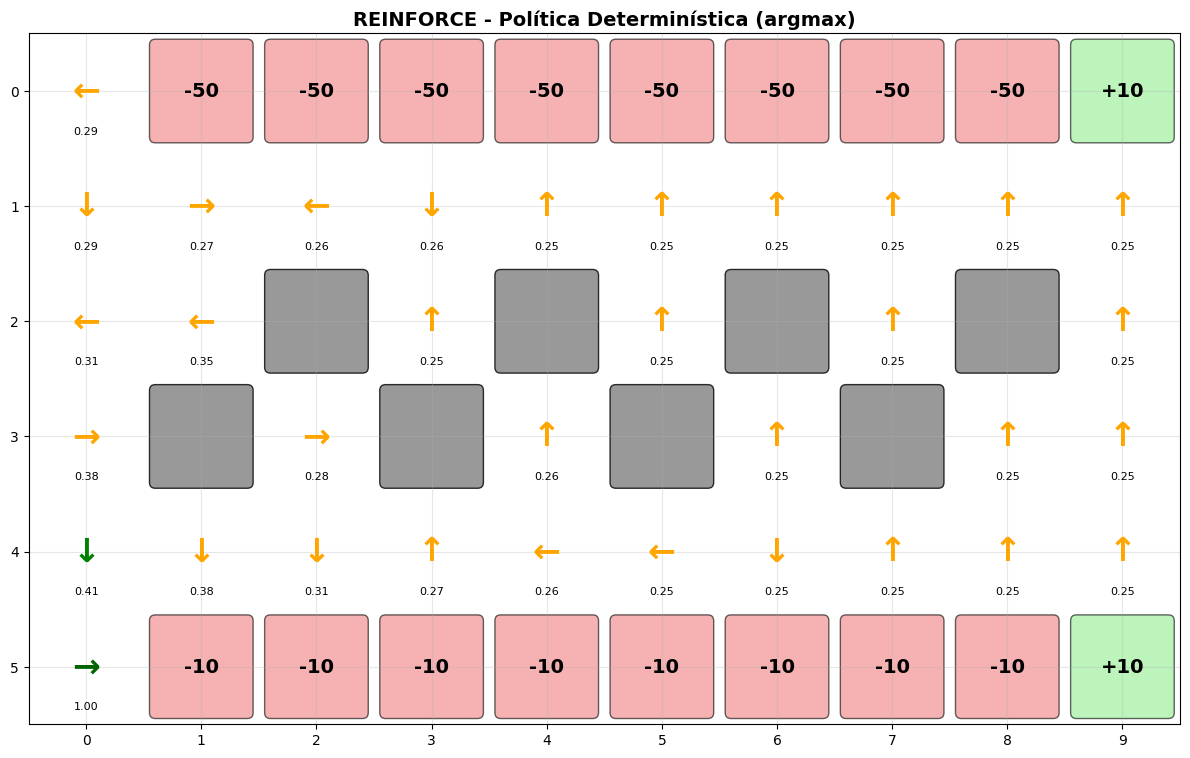

In [167]:
#### Política Determinística (Ação Mais Provável)


# Visualiza apenas a ação mais provável em cada estado
plot_policy_arrows(
    theta_reinforce,
    gw,
    title="REINFORCE - Política Determinística (argmax)",
    figsize=(12, 12)
)

## 6. REINFORCE com Baseline

### 6.1 Intuição

**REINFORCE com Baseline** é uma melhoria do REINFORCE que **reduz a variância** subtraindo uma baseline $b(s)$ do retorno $G_t$. A baseline mais comum é a **função valor** $V(s)$.

**Vantagens:**
- ✅ Menor variância → aprendizado mais estável
- ✅ Convergência mais rápida
- ✅ Baseline é aprendida simultaneamente
- 📊 Mesma convergência garantida (baseline não causa viés)

**Intuição da Baseline:**
- Se $G_t > V(s)$: a ação foi **melhor que o esperado** → aumenta probabilidade
- Se $G_t < V(s)$: a ação foi **pior que o esperado** → diminui probabilidade

### 6.2 Pseudocódigo

```
Inicializar θ (política) e w (baseline) arbitrariamente

Para cada episódio:
    Gerar episódio S₀, A₀, R₁, ..., Sₜ, Aₜ, Rₜ₊₁ seguindo π(·|·,θ)
    
    Para cada passo t do episódio:
        Gₜ ← Σₖ₌₀^∞ γᵏ Rₜ₊ₖ₊₁
        
        δₜ ← Gₜ - V(Sₜ, w)    # Advantage (vantagem)
        
        # Atualiza baseline
        w ← w + αw δₜ ∇V(Sₜ, w)
        
        # Atualiza política
        θ ← θ + αθ γᵗ δₜ ∇log π(Aₜ|Sₜ,θ)
```

### 6.3 Equações de Atualização

**Advantage (vantagem):**

$$\delta_t = G_t - V(S_t, w)$$

**Atualização da baseline:**

$$w \leftarrow w + \alpha_w \delta_t \nabla V(S_t, w)$$

No nosso caso, $V(S_t, w) = w_{s_t}$ (one-hot encoding), então $\nabla V(S_t, w) = \mathbf{e}_{s_t}$.

**Atualização da política:**

$$\theta \leftarrow \theta + \alpha_\theta \gamma^t \delta_t \nabla \log \pi(A_t|S_t, \theta)$$

In [170]:
### 6.4 Treinamento do REINFORCE com Baseline

print("="*80)
print("TREINANDO REINFORCE COM BASELINE")
print("="*80)

# Hiperparâmetros
ALPHA_THETA_RB = 2**-9  # Taxa para política (~0.002)
ALPHA_W = 2**-6         # Taxa para baseline (~0.016)

# Treina REINFORCE com Baseline
theta_rb, w_rb, rewards_rb = reinforce_baseline(
    gw,
    n_episodes=N_EPISODES_PG,
    alpha_theta=ALPHA_THETA_RB,
    alpha_w=ALPHA_W,
    gamma=GAMMA_PG,
    initial_state=INITIAL_STATE,
    verbose=False
)

print(f"\n✓ Treinamento concluído!")
print(f"Recompensa média últimos 100 episódios: {np.mean(rewards_rb[-100:]):.2f}")

TREINANDO REINFORCE COM BASELINE

✓ Treinamento concluído!
Recompensa média últimos 100 episódios: -10.00


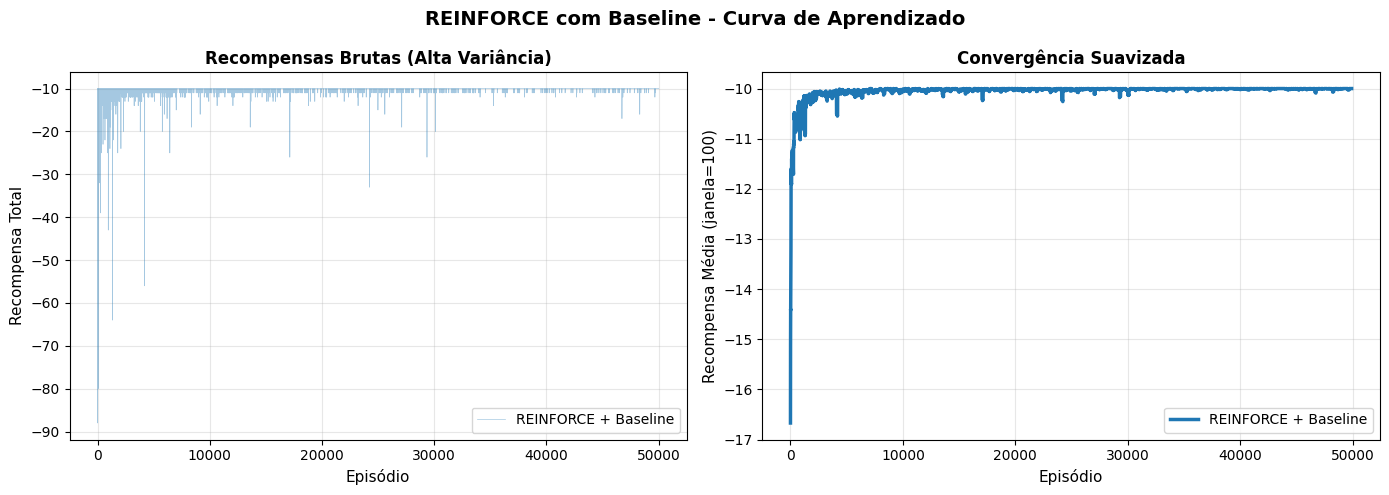

In [171]:
### 6.5 Visualização dos Resultados - REINFORCE Baseline

#### Curva de Aprendizado


plot_policy_gradient_learning(
    {'REINFORCE + Baseline': rewards_rb},
    title="REINFORCE com Baseline - Curva de Aprendizado",
    figsize=(14, 5)
)

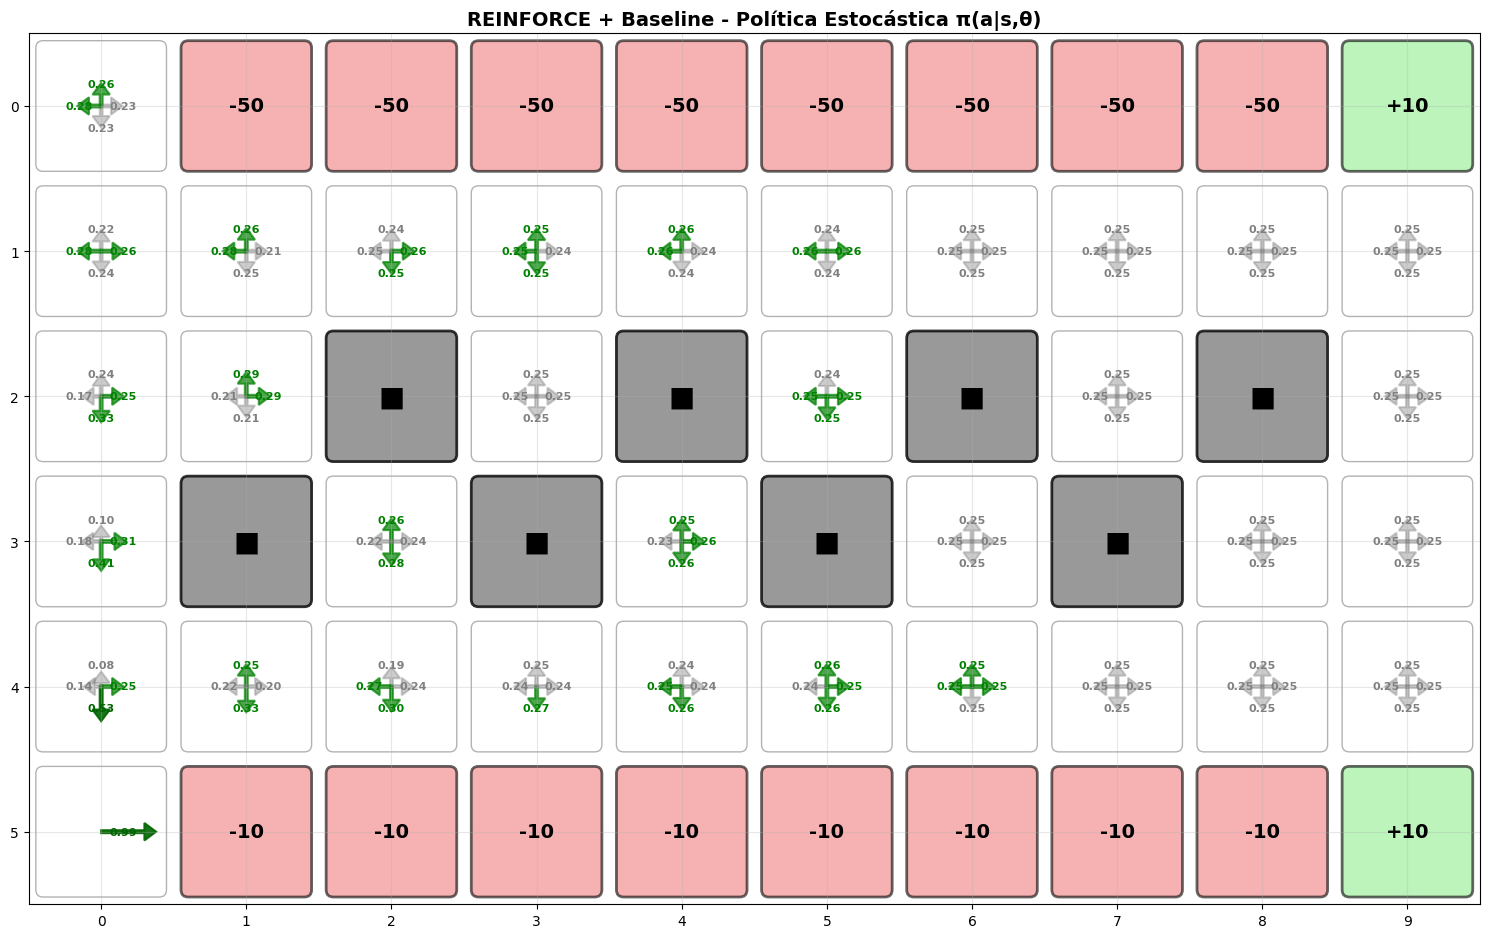

In [172]:
#### Política Estocástica Aprendida


# Visualiza política estocástica
visualize_stochastic_policy(
    theta_rb,
    gw,
    title="REINFORCE + Baseline - Política Estocástica π(a|s,θ)",
    figsize=(15, 15),
    show_probs=True
)

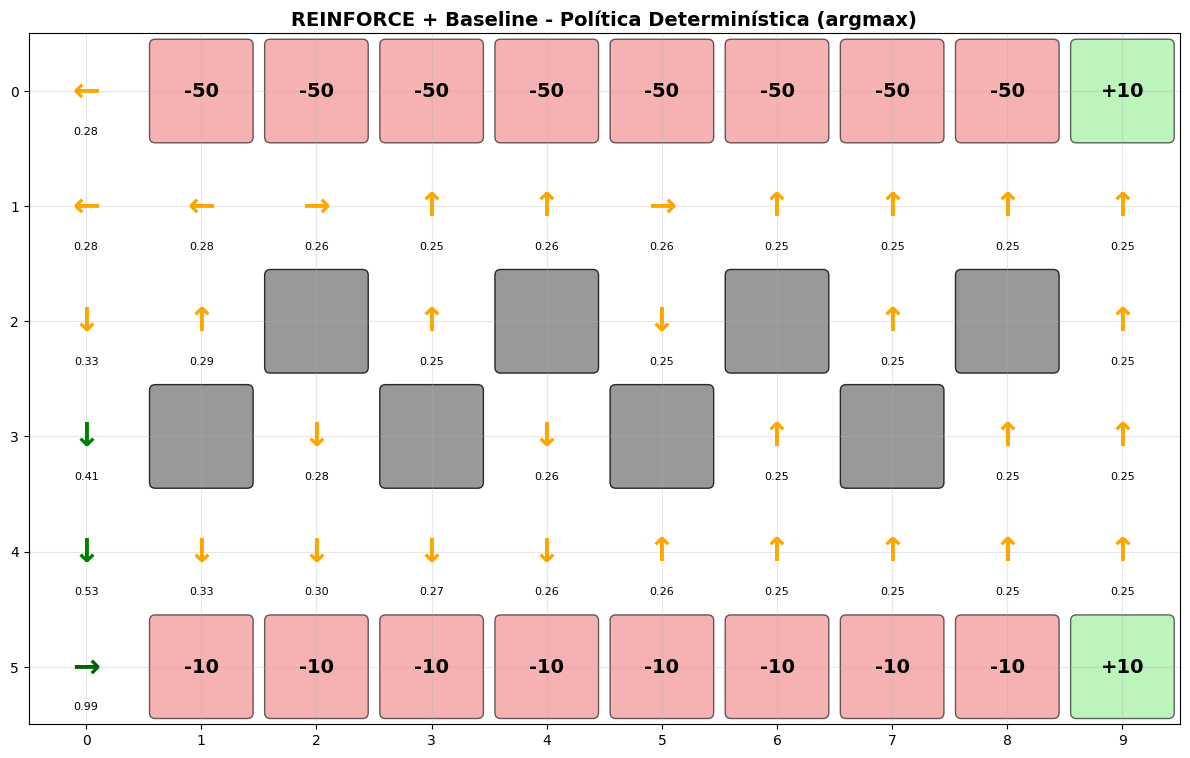

In [173]:
#### Política Determinística


# Visualiza ação mais provável
plot_policy_arrows(
    theta_rb,
    gw,
    title="REINFORCE + Baseline - Política Determinística (argmax)",
    figsize=(12, 12)
)

## 7. Actor-Critic (One-Step)

### 7.1 Intuição

**Actor-Critic** combina o melhor de dois mundos:
- **Actor (Ator)**: Aprende a política $\pi(a|s, \theta)$ (como REINFORCE)
- **Critic (Crítico)**: Aprende a função valor $V(s, w)$ (como TD)

**Vantagens sobre REINFORCE:**
- ✅ Atualização **online** (a cada passo, não no fim do episódio)
- ✅ **Bootstrapping**: usa $V(s')$ ao invés de $G_t$ → menor variância
- ✅ Mais eficiente em termos de dados
- 📊 Baseline aprendida pelo critic automaticamente

**Componentes:**
1. **Actor**: Política $\pi(a|s, \theta)$ que escolhe ações
2. **Critic**: Função valor $V(s, w)$ que avalia estados
3. **TD Error**: $\delta = R + \gamma V(s') - V(s)$ guia ambos

### 7.2 Pseudocódigo

```
Inicializar θ (actor) e w (critic) arbitrariamente

Para cada episódio:
    S ← estado inicial
    I ← 1  # Fator de desconto acumulado
    
    Enquanto S não é terminal:
        A ~ π(·|S,θ)              # Actor escolhe ação
        Executar A, observar R, S'
        
        # Calcula TD error
        δ ← R + γ V(S',w) - V(S,w)
        
        # Atualiza Critic
        w ← w + αw δ ∇V(S,w)
        
        # Atualiza Actor
        θ ← θ + αθ I δ ∇log π(A|S,θ)
        
        I ← γI
        S ← S'
```

### 7.3 Equações de Atualização

**TD Error (sinal de ensino):**

$$\delta_t = R_{t+1} + \gamma V(S_{t+1}, w) - V(S_t, w)$$

**Atualização do Critic:**

$$w \leftarrow w + \alpha_w \delta_t \nabla V(S_t, w)$$

**Atualização do Actor:**

$$\theta \leftarrow \theta + \alpha_\theta I_t \delta_t \nabla \log \pi(A_t|S_t, \theta)$$

onde $I_t = \gamma^t$ é o fator de desconto acumulado.

In [174]:
### 7.4 Treinamento do Actor-Critic

print("="*80)
print("TREINANDO ACTOR-CRITIC")
print("="*80)

# Hiperparâmetros
ALPHA_THETA_AC = 0.05  # Taxa para actor
ALPHA_W_AC = 0.015     # Taxa para critic

# Treina Actor-Critic
theta_ac, w_ac, rewards_ac = actor_critic(
    gw,
    n_episodes=N_EPISODES_PG,
    alpha_theta=ALPHA_THETA_AC,
    alpha_w=ALPHA_W_AC,
    gamma=GAMMA_PG,
    initial_state=INITIAL_STATE,
    verbose=True
)

print(f"\n✓ Treinamento concluído!")
print(f"Recompensa média últimos 100 episódios: {np.mean(rewards_ac[-100:]):.2f}")

TREINANDO ACTOR-CRITIC
EpisÃ³dio 100/50000 - Reward mÃ©dio: -59.54
EpisÃ³dio 200/50000 - Reward mÃ©dio: -11.60
EpisÃ³dio 300/50000 - Reward mÃ©dio: -9.82
EpisÃ³dio 400/50000 - Reward mÃ©dio: -31.66
EpisÃ³dio 500/50000 - Reward mÃ©dio: -10.75
EpisÃ³dio 600/50000 - Reward mÃ©dio: -3.45
EpisÃ³dio 700/50000 - Reward mÃ©dio: -1.44
EpisÃ³dio 800/50000 - Reward mÃ©dio: -0.23
EpisÃ³dio 900/50000 - Reward mÃ©dio: -0.51
EpisÃ³dio 1000/50000 - Reward mÃ©dio: -0.33
EpisÃ³dio 1100/50000 - Reward mÃ©dio: -0.13
EpisÃ³dio 1200/50000 - Reward mÃ©dio: -0.12
EpisÃ³dio 1300/50000 - Reward mÃ©dio: -0.25
EpisÃ³dio 1400/50000 - Reward mÃ©dio: -0.23
EpisÃ³dio 1500/50000 - Reward mÃ©dio: -0.24
EpisÃ³dio 1600/50000 - Reward mÃ©dio: -0.41
EpisÃ³dio 1700/50000 - Reward mÃ©dio: -0.01
EpisÃ³dio 1800/50000 - Reward mÃ©dio: -0.18
EpisÃ³dio 1900/50000 - Reward mÃ©dio: -0.09
EpisÃ³dio 2000/50000 - Reward mÃ©dio: -0.01
EpisÃ³dio 2100/50000 - Reward mÃ©dio: -0.02
EpisÃ³dio 2200/50000 - Reward mÃ©dio: -0.12
EpisÃ³dio 2300

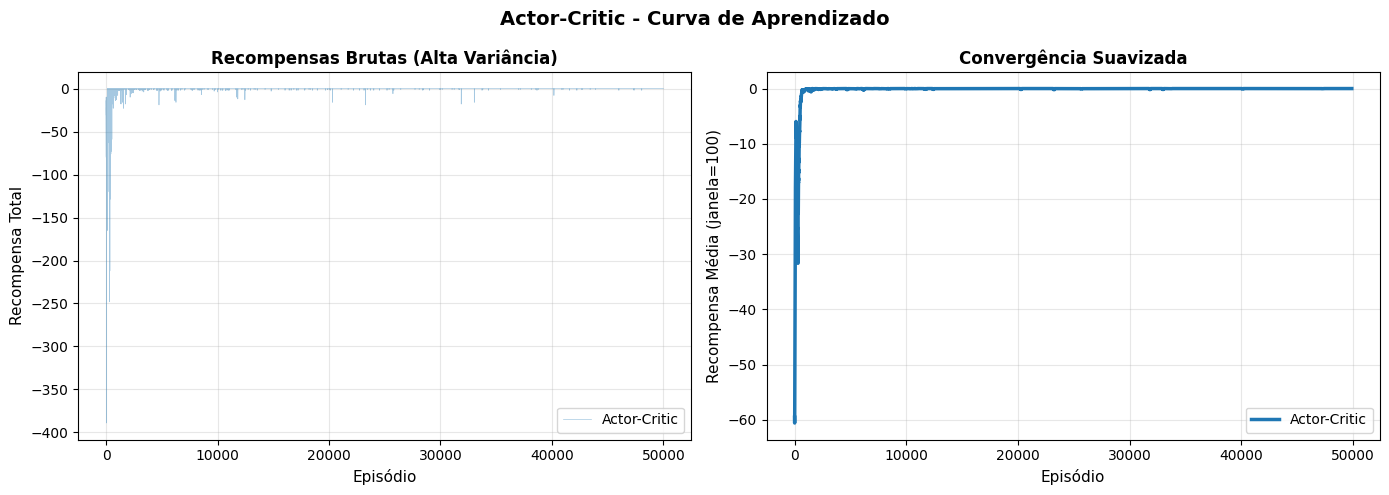

In [175]:
### 7.5 Visualização dos Resultados - Actor-Critic

#### Curva de Aprendizado


plot_policy_gradient_learning(
    {'Actor-Critic': rewards_ac},
    title="Actor-Critic - Curva de Aprendizado",
    figsize=(14, 5)
)

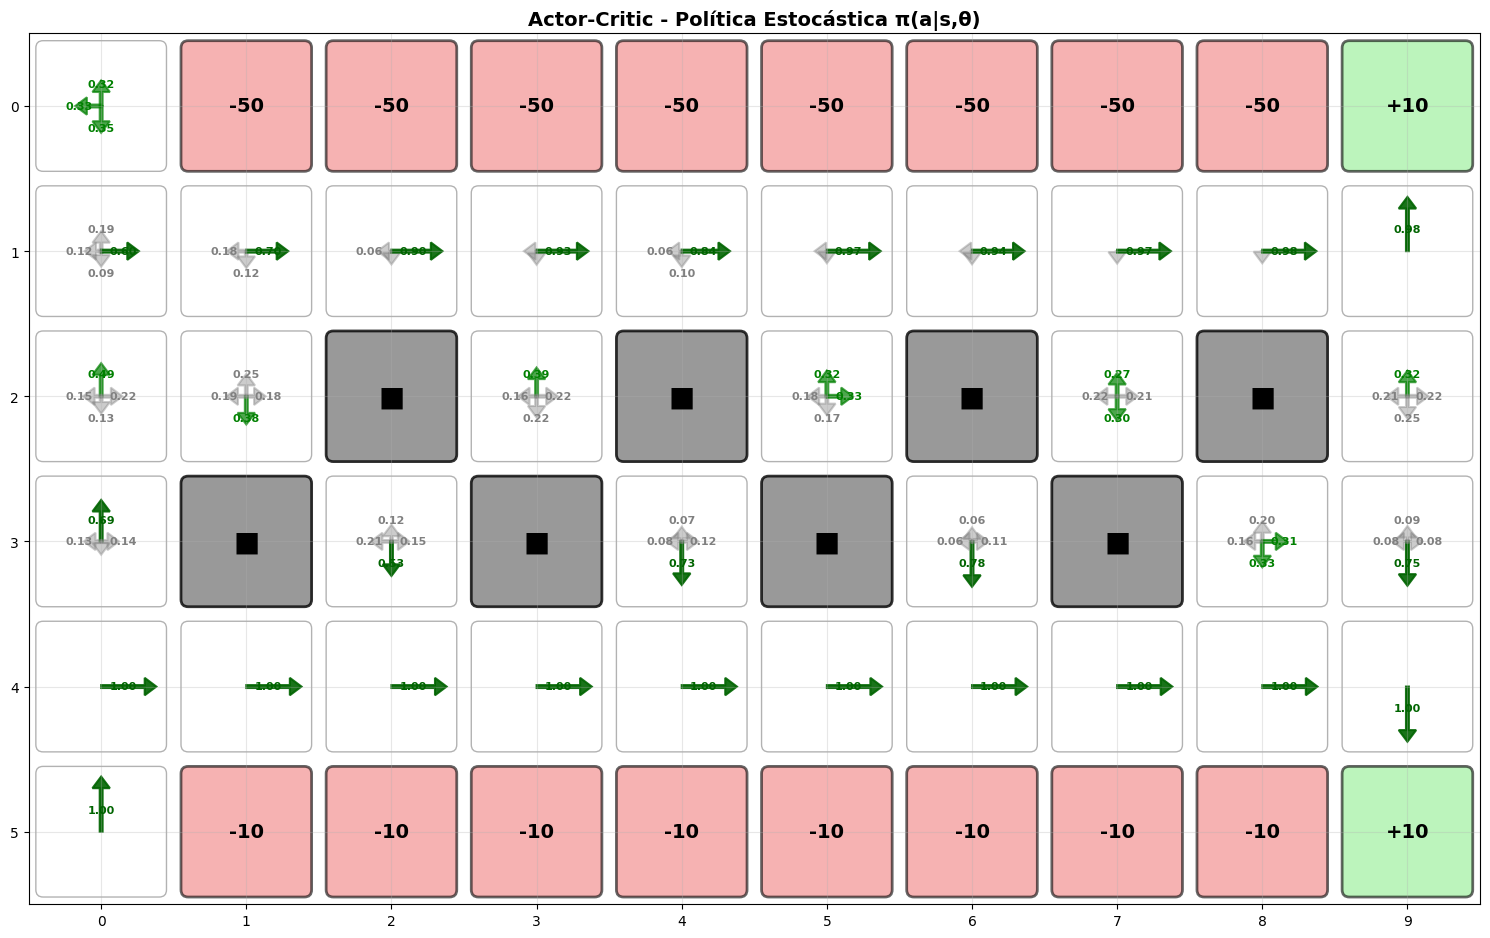

In [176]:
#### Política Estocástica Aprendida


# Visualiza política estocástica
visualize_stochastic_policy(
    theta_ac,
    gw,
    title="Actor-Critic - Política Estocástica π(a|s,θ)",
    figsize=(15, 15),
    show_probs=True
)

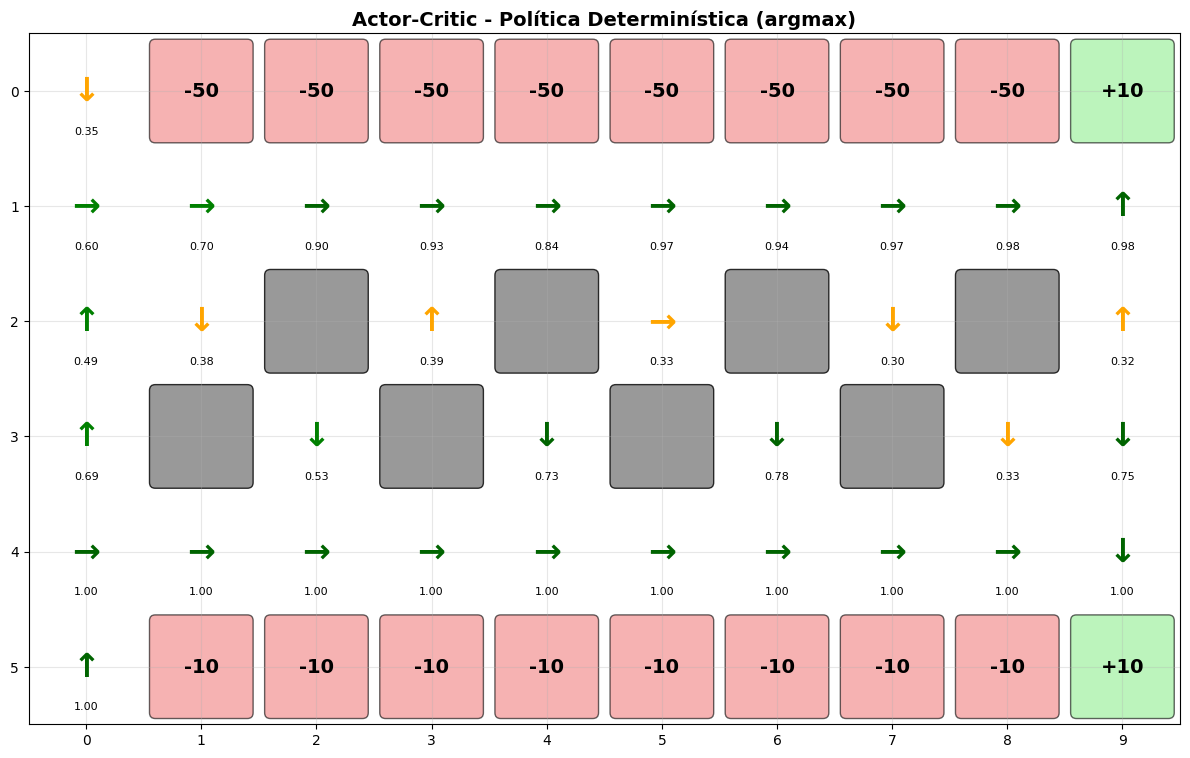

In [177]:
#### Política Determinística


# Visualiza ação mais provável
plot_policy_arrows(
    theta_ac,
    gw,
    title="Actor-Critic - Política Determinística (argmax)",
    figsize=(12, 12)
)

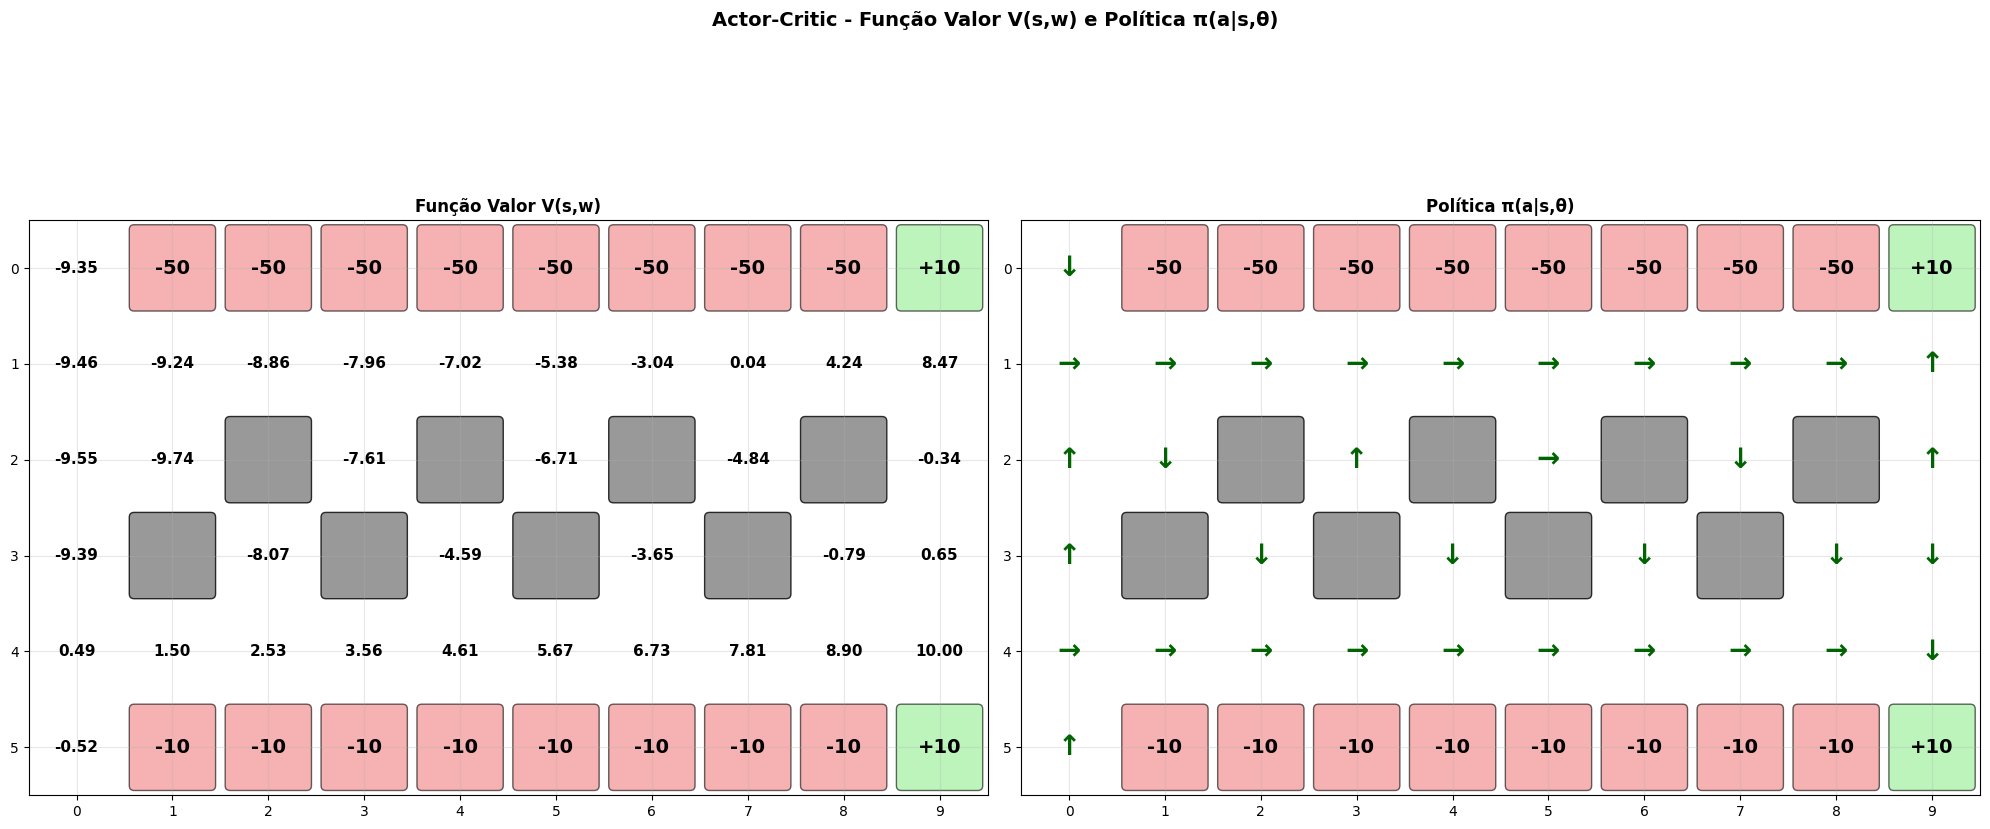

In [178]:
#### Função Valor e Política Juntas


# Visualização especial: Critic (valores) e Actor (política) lado a lado
plot_value_and_policy(
    w_ac,
    theta_ac,
    gw,
    title="Actor-Critic - Função Valor V(s,w) e Política π(a|s,θ)",
    figsize=(20, 10)
)

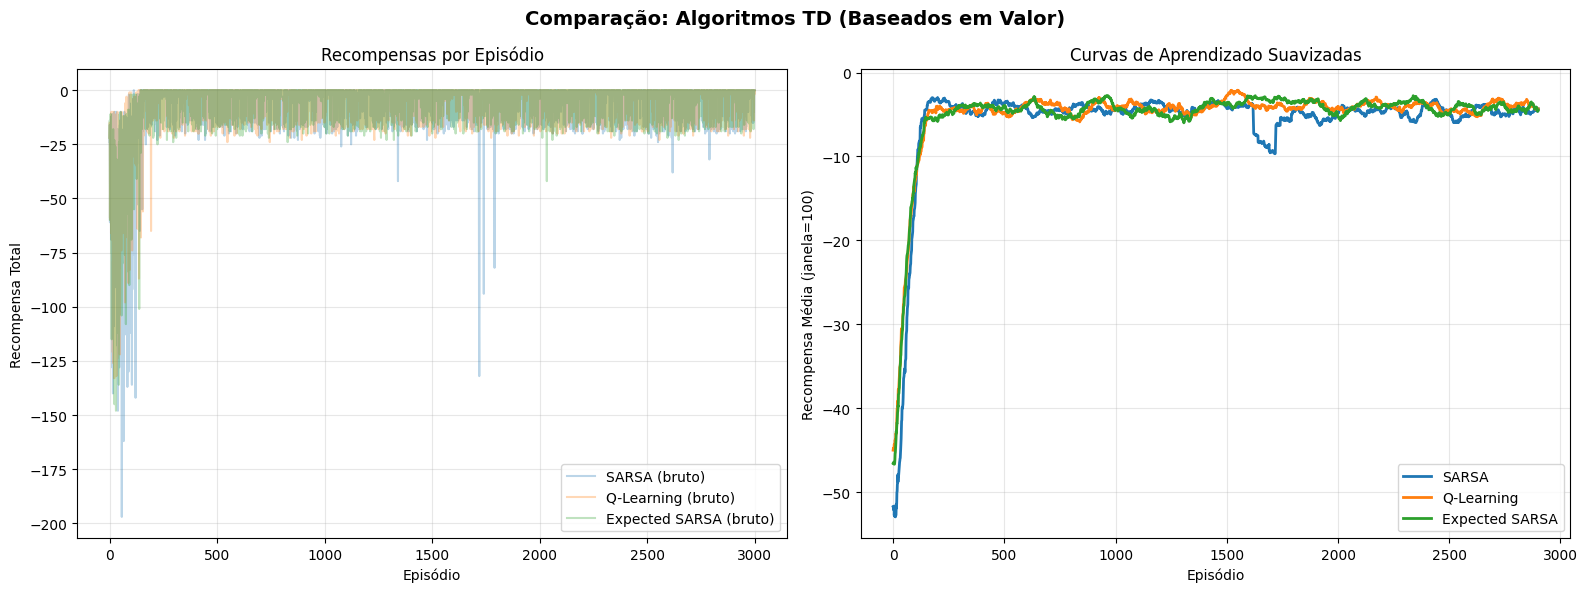

In [179]:
## 8. Comparação Final

### 8.1 Comparação das Curvas de Aprendizado

#### Algoritmos Baseados em Valor (TD)


# Compara SARSA, Q-Learning e Expected SARSA
plot_learning_curves(
    {
        'SARSA': rewards_sarsa,
        'Q-Learning': rewards_qlearning,
        'Expected SARSA': rewards_expected
    },
    title="Comparação: Algoritmos TD (Baseados em Valor)",
    figsize=(16, 6)
)

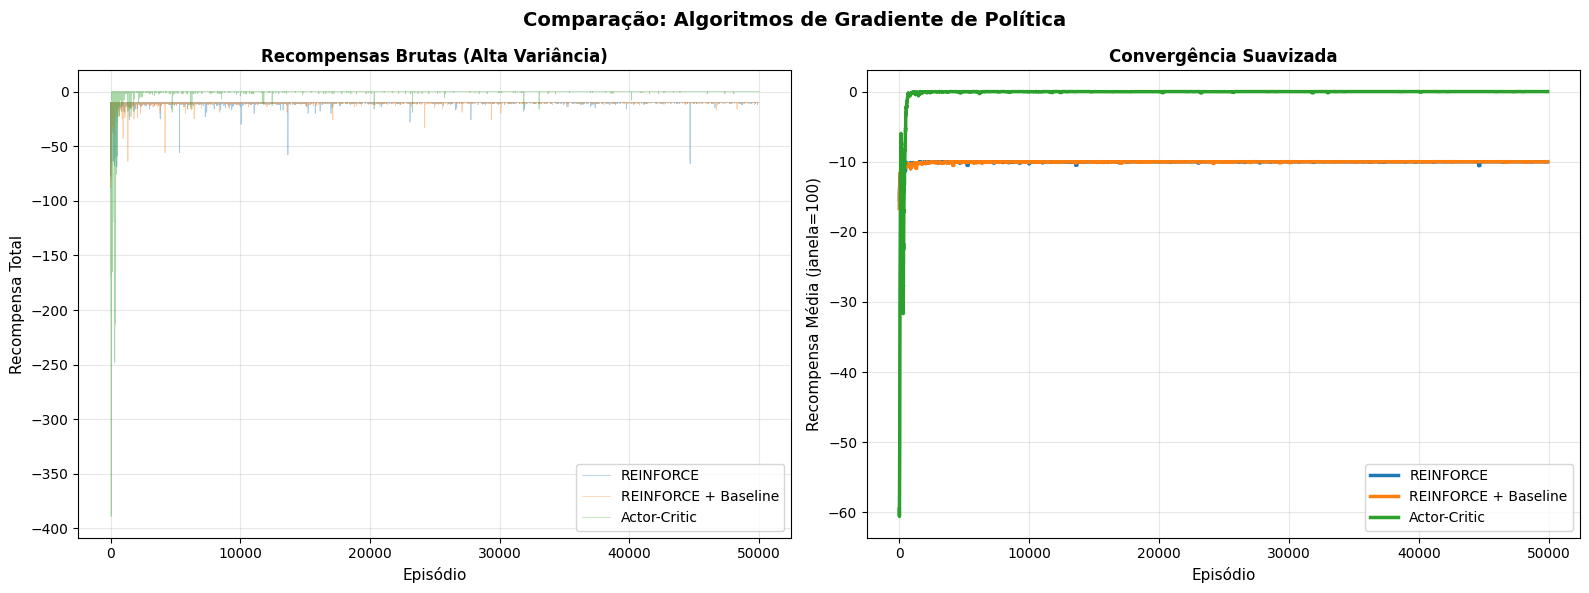

In [180]:
#### Algoritmos de Gradiente de Política


# Compara REINFORCE, REINFORCE+Baseline e Actor-Critic
plot_policy_gradient_learning(
    {
        'REINFORCE': rewards_reinforce,
        'REINFORCE + Baseline': rewards_rb,
        'Actor-Critic': rewards_ac
    },
    title="Comparação: Algoritmos de Gradiente de Política",
    figsize=(16, 6)
)

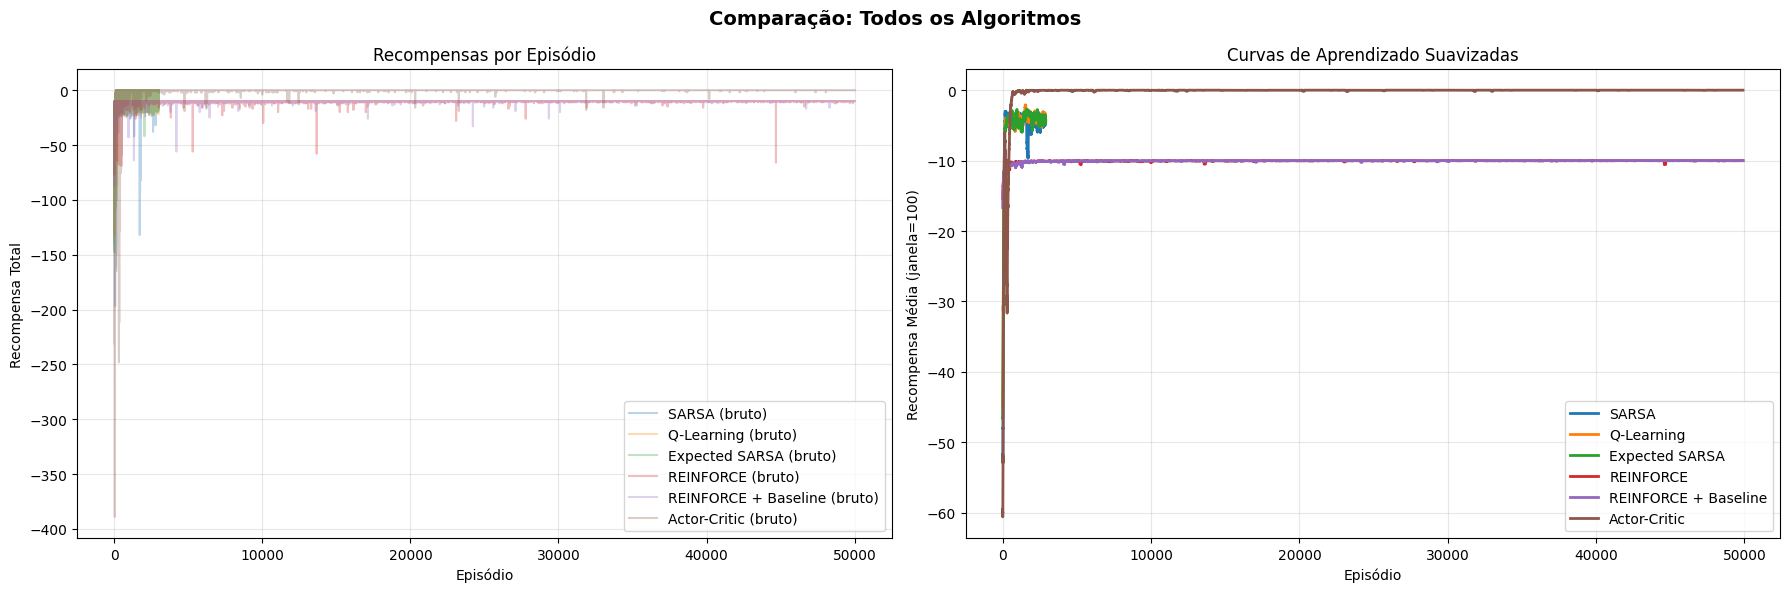

In [181]:
#### Todos os Algoritmos Juntos


# Comparação completa
plot_learning_curves(
    {
        'SARSA': rewards_sarsa,
        'Q-Learning': rewards_qlearning,
        'Expected SARSA': rewards_expected,
        'REINFORCE': rewards_reinforce,
        'REINFORCE + Baseline': rewards_rb,
        'Actor-Critic': rewards_ac
    },
    title="Comparação: Todos os Algoritmos",
    figsize=(18, 6)
)

In [182]:
### 8.2 Comparação dos Valores Aprendidos (TD)


# Compara valores Q aprendidos pelos algoritmos TD
compare_algorithms(
    {
        'SARSA': Q_sarsa,
        'Q-Learning': Q_qlearning,
        'Expected SARSA': Q_expected
    },
    gw
)

COMPARAÇÃO DE VALORES APRENDIDOS

Estado         SARSA               Q-Learning          Expected SARSA      
--------------------------------------------------------------------------------
(0, 0)         -3.9285             -4.1220             -4.5912             
(1, 0)         -5.4031             -4.2022             -4.8257             
(1, 1)         -5.2504             -3.9843             -4.4797             
(1, 2)         -5.0911             -3.5681             -4.1304             
(1, 3)         -5.4881             -3.1083             -3.5249             
(1, 4)         -4.5000             -2.4709             -2.9832             
(1, 5)         -2.1422             -1.5088             -1.9845             
(1, 6)         -1.5486             0.0893              -0.7262             
(1, 7)         -0.4536             2.6875              1.5743              
(1, 8)         1.3807              5.9706              5.1470              
(1, 9)         6.5132              9.4767        

In [183]:
### 8.3 Estatísticas Resumidas


print("\n" + "="*80)
print("ESTATÍSTICAS RESUMIDAS - TODOS OS ALGORITMOS")
print("="*80)

algorithms_results = {
    'SARSA': rewards_sarsa,
    'Q-Learning': rewards_qlearning,
    'Expected SARSA': rewards_expected,
    'REINFORCE': rewards_reinforce,
    'REINFORCE + Baseline': rewards_rb,
    'Actor-Critic': rewards_ac
}

print(f"\n{'Algoritmo':<25} {'Média Final':<15} {'Std Final':<15} {'Melhor':<15}")
print("-"*80)

for name, rewards in algorithms_results.items():
    final_mean = np.mean(rewards[-100:])
    final_std = np.std(rewards[-100:])
    best = np.max(rewards)
    print(f"{name:<25} {final_mean:<15.2f} {final_std:<15.2f} {best:<15.2f}")

print("="*80)


ESTATÍSTICAS RESUMIDAS - TODOS OS ALGORITMOS

Algoritmo                 Média Final     Std Final       Melhor         
--------------------------------------------------------------------------------
SARSA                     -4.32           6.55            0.00           
Q-Learning                -4.33           6.28            0.00           
Expected SARSA            -4.46           6.33            0.00           
REINFORCE                 -10.00          0.00            -10.00         
REINFORCE + Baseline      -10.00          0.00            -10.00         
Actor-Critic              0.00            0.00            0.00           


### 8.4 Análise Comparativa


### ANÁLISE COMPARATIVA


🔍 ALGORITMOS TD (Baseados em Valor):
---

✓ SARSA (On-Policy):
  • Aprende a política que está seguindo (incluindo ε-exploration)
  • Mais conservador e seguro
  • Evita caminhos muito próximos ao abismo
  • Convergência estável

✓ Q-Learning (Off-Policy):
  • Aprende a política ótima diretamente
  • Mais agressivo, pode encontrar caminhos arriscados
  • Convergência mais rápida
  • Pode escolher caminhos próximos ao abismo (ótimos mas arriscados)

✓ Expected SARSA:
  • Reduz variância usando valor esperado
  • Compromisso entre SARSA e Q-Learning
  • Convergência suave e estável
  

🎭 ALGORITMOS DE GRADIENTE DE POLÍTICA:
---

✓ REINFORCE:
  • Aprende política estocástica diretamente
  • Alta variância (usa retornos completos Gt)
  • Atualizações apenas no fim do episódio
  • Requer muitos episódios para convergir

✓ REINFORCE + Baseline:
  • Reduz variância usando baseline V(s)
  • Convergência mais rápida que REINFORCE puro
  • Ainda episódico (atualiza no fim)
  • Aprende baseline automaticamente

✓ Actor-Critic:
  • Atualização ONLINE (a cada passo)
  • Bootstrapping reduz variância
  • Mais eficiente em dados
  • Combina vantagens de TD e Policy Gradient
  

🏆 COMPARAÇÃO GERAL:
---

### Velocidade de Convergência:
  1. Q-Learning (mais rápido)
  2. Expected SARSA
  3. SARSA
  4. Actor-Critic
  5. REINFORCE + Baseline
  6. REINFORCE (mais lento)

### Estabilidade:
  1. Expected SARSA (mais estável)
  2. Actor-Critic
  3. SARSA
  4. REINFORCE + Baseline
  5. Q-Learning
  6. REINFORCE (mais instável)

### Eficiência em Dados:
  • TD methods > Policy Gradient methods
  • Actor-Critic > REINFORCE variants

### Aplicabilidade:
  • TD methods: Excelentes para espaços discretos
  • Policy Gradient: Escaláveis para contínuos/alta dimensão

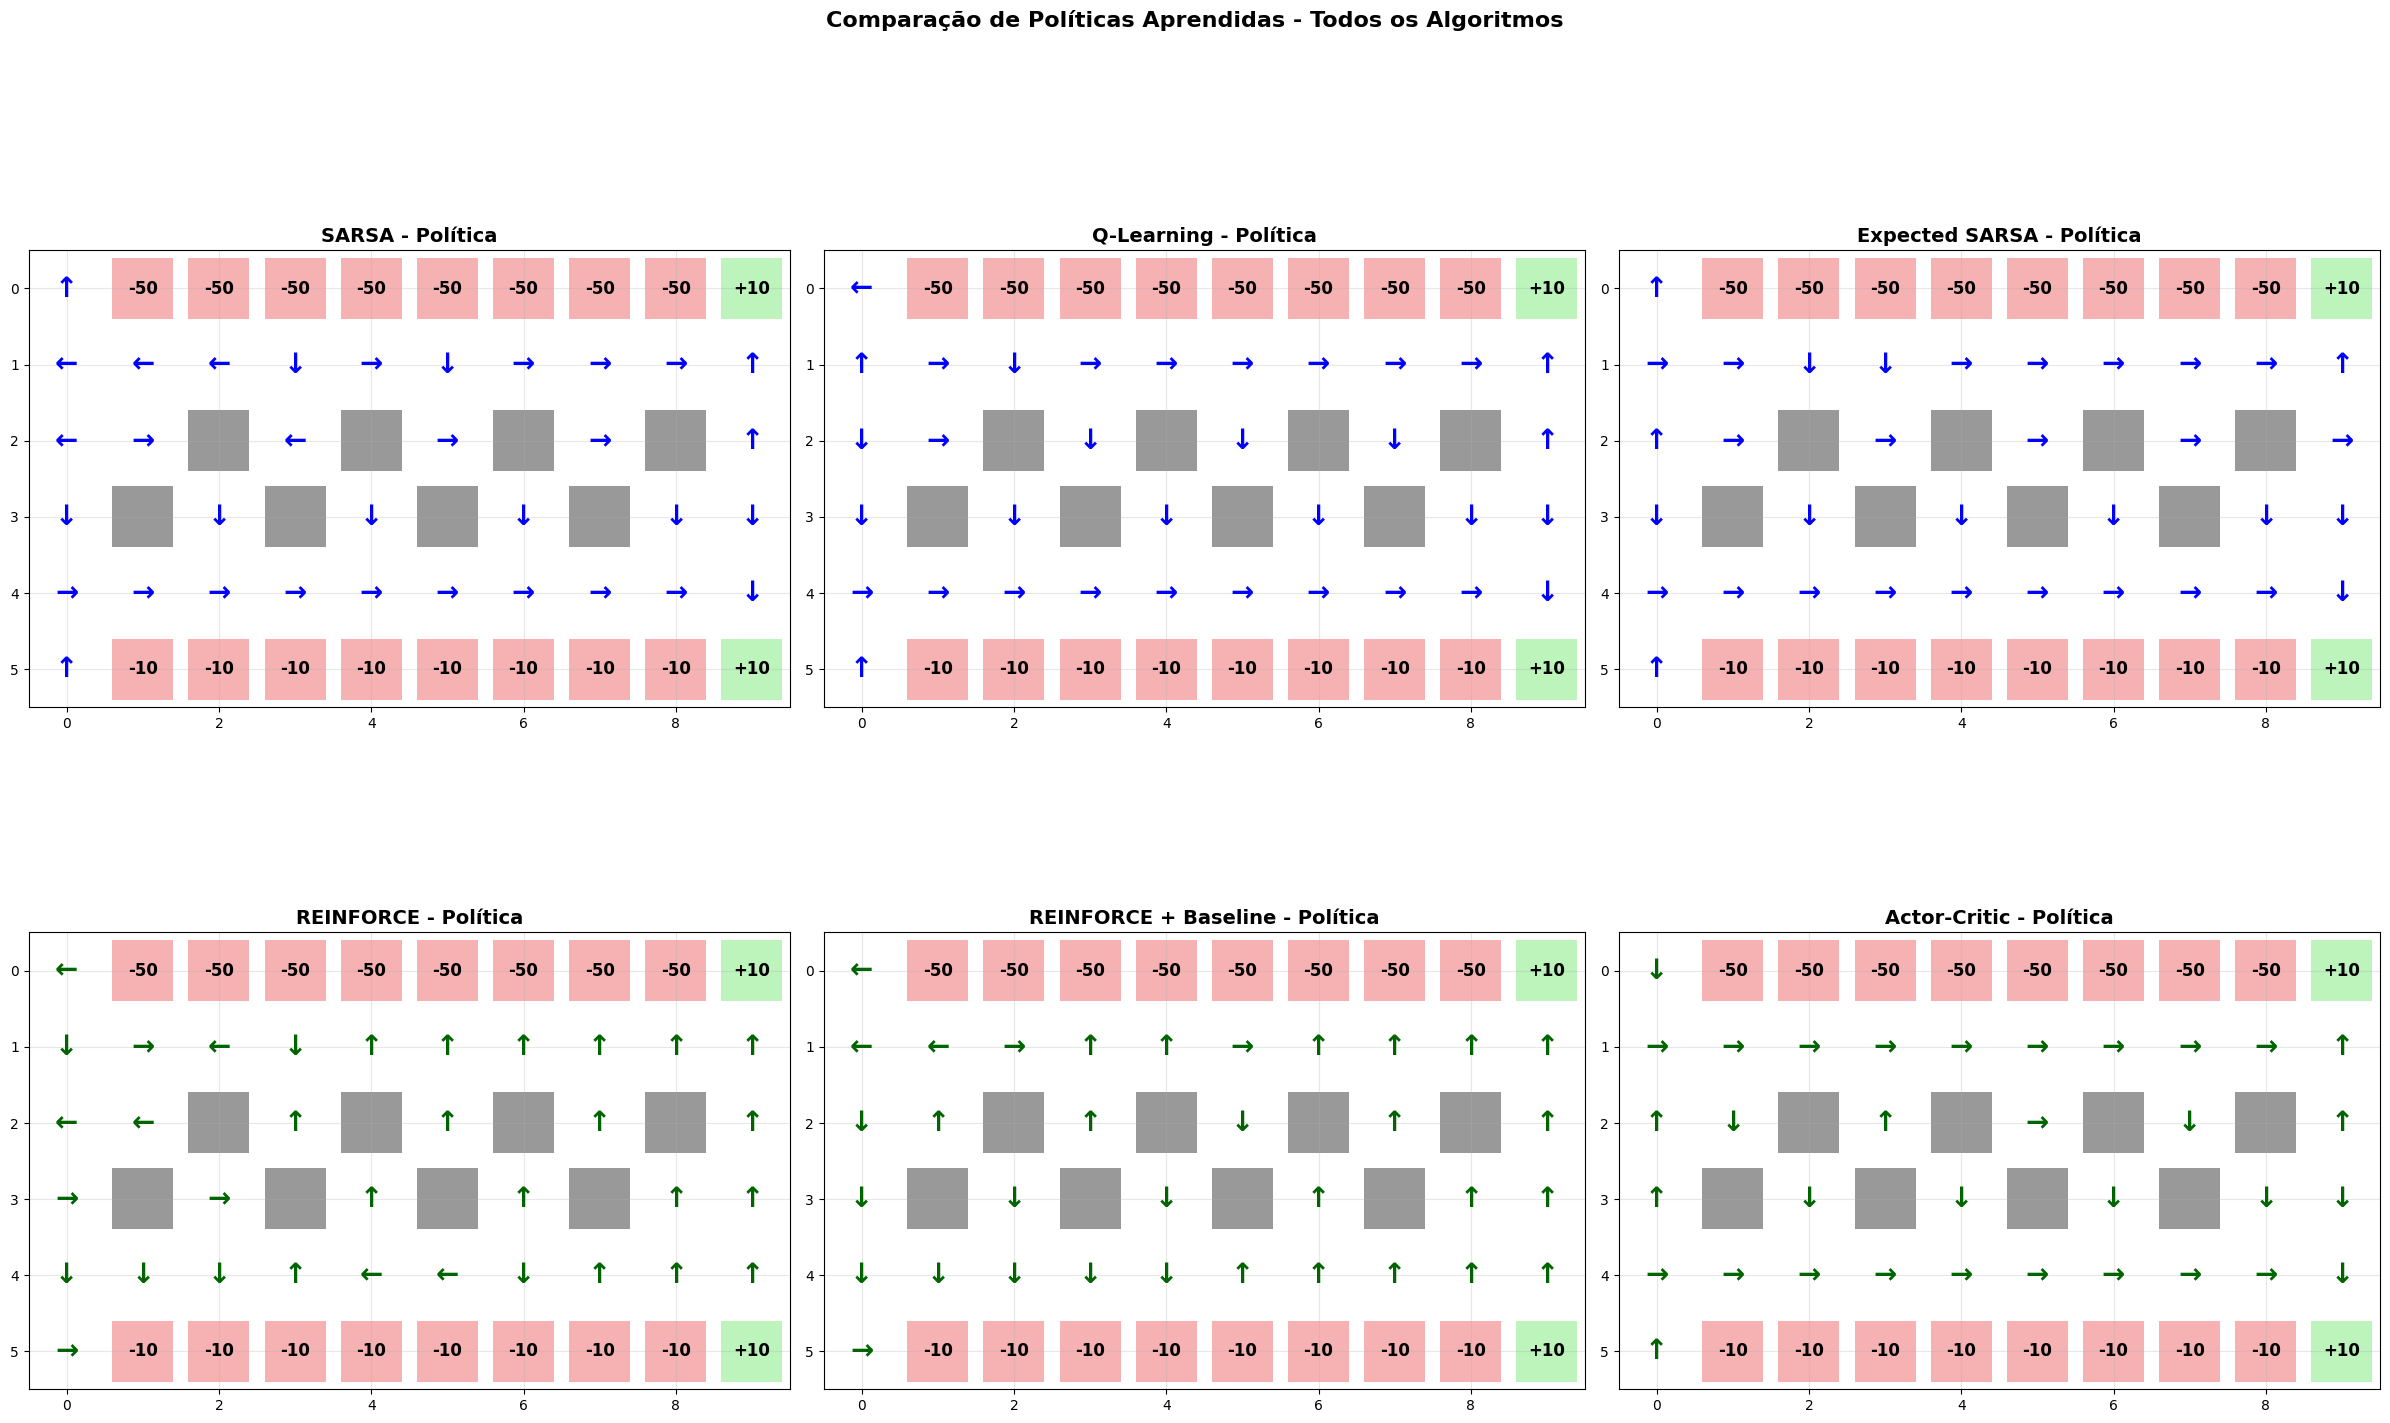

In [184]:
### 8.5 Visualização Final - Grade Comparativa de Políticas

# Cria visualização comparativa das políticas aprendidas
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# Políticas TD
for idx, (name, Q, ax) in enumerate([
    ('SARSA', Q_sarsa, axes[0, 0]),
    ('Q-Learning', Q_qlearning, axes[0, 1]),
    ('Expected SARSA', Q_expected, axes[0, 2])
]):
    policy = get_greedy_policy(Q, gw)
    
    ax.set_xlim(-0.5, gw.cols - 0.5)
    ax.set_ylim(gw.rows - 0.5, -0.5)
    ax.set_aspect('equal')
    ax.set_title(f'{name} - Política', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    action_symbols = {'N': '↑', 'S': '↓', 'L': '→', 'O': '←'}
    
    for row in range(gw.rows):
        for col in range(gw.cols):
            state = (row, col)
            
            if state in gw.walls:
                ax.add_patch(plt.Rectangle((col-0.4, row-0.4), 0.8, 0.8, 
                                          facecolor='gray', alpha=0.8))
            elif state in gw.terminal_states:
                reward = gw.terminal_states[state]
                color = 'lightgreen' if reward > 0 else 'lightcoral'
                ax.add_patch(plt.Rectangle((col-0.4, row-0.4), 0.8, 0.8,
                                          facecolor=color, alpha=0.6))
                ax.text(col, row, f'{reward:+.0f}', ha='center', va='center',
                       fontsize=12, fontweight='bold')
            elif state in policy:
                action = policy[state]
                symbol = action_symbols[action]
                ax.text(col, row, symbol, ha='center', va='center',
                       fontsize=20, fontweight='bold', color='blue')
# Políticas PG (mostrar ação mais provável)
from algorithms_extended import compute_softmax_policy

for idx, (name, theta, ax) in enumerate([
    ('REINFORCE', theta_reinforce, axes[1, 0]),
    ('REINFORCE + Baseline', theta_rb, axes[1, 1]),
    ('Actor-Critic', theta_ac, axes[1, 2])
]):
    ax.set_xlim(-0.5, gw.cols - 0.5)
    ax.set_ylim(gw.rows - 0.5, -0.5)
    ax.set_aspect('equal')
    ax.set_title(f'{name} - Política', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    action_symbols = {'N': '↑', 'S': '↓', 'L': '→', 'O': '←'}
    
    for row in range(gw.rows):
        for col in range(gw.cols):
            state = (row, col)
            
            if state in gw.walls:
                ax.add_patch(plt.Rectangle((col-0.4, row-0.4), 0.8, 0.8,
                                          facecolor='gray', alpha=0.8))
            elif state in gw.terminal_states:
                reward = gw.terminal_states[state]
                color = 'lightgreen' if reward > 0 else 'lightcoral'
                ax.add_patch(plt.Rectangle((col-0.4, row-0.4), 0.8, 0.8,
                                          facecolor=color, alpha=0.6))
                ax.text(col, row, f'{reward:+.0f}', ha='center', va='center',
                       fontsize=12, fontweight='bold')
            else:
                probs = compute_softmax_policy(state, theta, gw)
                best_action_idx = np.argmax(probs)
                best_action = gw.actions[best_action_idx]
                symbol = action_symbols[best_action]
                ax.text(col, row, symbol, ha='center', va='center',
                       fontsize=20, fontweight='bold', color='darkgreen')

plt.suptitle('Comparação de Políticas Aprendidas - Todos os Algoritmos',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 📊 Conclusões

### Principais Aprendizados:

1. **Algoritmos TD** convergem mais rápido e são mais eficientes em dados para ambientes discretos
2. **Q-Learning** encontra políticas mais agressivas (próximas ao abismo)
3. **SARSA** aprende políticas mais conservadoras (caminho seguro)
4. **Expected SARSA** oferece o melhor equilíbrio entre velocidade e estabilidade

5. **REINFORCE** tem alta variância mas funciona bem com ajuste de hiperparâmetros
6. **Baseline** reduz significativamente a variância do REINFORCE
7. **Actor-Critic** combina vantagens de TD e PG, sendo o mais versátil

### Quando usar cada algoritmo?

**SARSA**: 
- Quando a exploração tem custo real
- Ambientes onde segurança é importante

**Q-Learning**:
- Quando queremos a política ótima rapidamente
- Podemos tolerar exploração agressiva

**Expected SARSA**:
- Melhor escolha geral para TD
- Boa estabilidade e velocidade

**REINFORCE**:
- Espaços de ação contínuos
- Quando política estocástica é desejável

**REINFORCE + Baseline**:
- Versão melhorada do REINFORCE
- Sempre preferível ao REINFORCE puro

**Actor-Critic**:
- Alta dimensão / espaços contínuos
- Atualizações online são importantes
- Boa opção geral para deep RL

---

## 🎓 Referências

- **Sutton & Barto (2018)**: Reinforcement Learning: An Introduction (2nd Ed.)
  - Capítulo 6: Temporal-Difference Learning
  - Capítulo 13: Policy Gradient Methods